In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import pickle
from time import ctime
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.core.base import Constraint as pyo_constraint
from pyomo.core.base import Var as pyo_vars

### Data processing functions

In [2]:
def load_input_data(input_data):
    """
    Return input data as numpy arrays in a dictionary.
    """

    # parse the input
    lines = input_data.split('\n')

    firstLine = lines[0].split()
    num_facilities = int(firstLine[0])
    num_customers = int(firstLine[1])
    
    data_dict = {}

    facility_cost_array = np.zeros(num_facilities)
    facility_capacity_array = np.zeros(num_facilities)
    facility_location_array = np.zeros((num_facilities, 2))
    for i in range(num_facilities):
        line = lines[i + 1]
        parts = line.split()
        facility_cost_array[i] = parts[0]
        facility_capacity_array[i] = parts[1]
        facility_location_array[i,:] = np.array([parts[2], parts[3]])
        
    data_dict['facility_cost_array'] = facility_cost_array
    data_dict['facility_capacity_array'] = facility_capacity_array
    data_dict['facility_location_array'] = facility_location_array

    customer_demand_array = np.zeros(num_customers)
    customer_location_array = np.zeros((num_customers, 2))
    for i in range(num_customers):
        line = lines[i + 1 + num_facilities]
        parts = line.split()
        customer_demand_array[i] = parts[0]
        customer_location_array[i,:] = np.array([parts[1], parts[2]])
        
    data_dict['customer_demand_array'] = customer_demand_array
    data_dict['customer_location_array'] = customer_location_array
    
    return data_dict

In [88]:
input_file = open('data/fl_500_7','r').read()

In [89]:
data_dict = load_input_data(input_file)

In [5]:
data_dict

{'facility_cost_array': array([100., 100., 100.]),
 'facility_capacity_array': array([100., 100., 500.]),
 'facility_location_array': array([[1065., 1065.],
        [1062., 1062.],
        [   0.,    0.]]),
 'customer_demand_array': array([50., 50., 75., 75.]),
 'customer_location_array': array([[1397., 1397.],
        [1398., 1398.],
        [1399., 1399.],
        [ 586.,  586.]])}

In [5]:
def get_solution(data_dict, results_dict):
    
    solution = np.zeros(len(data_dict['customer_location_array']))
    for facility, customer_list in results_dict['facility_customers'].items():
        solution[customer_list] = facility
        
    return solution.astype(int)

In [22]:
solution = get_solution(data_dict, results_dict)
solution

array([0, 0, 1, 2])

In [6]:
def prepare_output_data(data_dict, results_dict, is_provably_optimal=False):
    """
    Return output in specified format.
    """
    
    if is_provably_optimal:
        optimal = str(1)
    else:
        optimal = str(0)
        
    solution = get_solution(data_dict, results_dict)
    
    output_data = str(results_dict['objective_value']) + ' ' + optimal + '\n'
    output_data += ' '.join(map(str, solution.astype(int)))
    
    return output_data

In [152]:
prepare_output_data(data_dict, results_dict, is_provably_optimal=False)

In [7]:
def create_facility_customer_dist_matrix(data_dict):
    
    """
    Distance matrix between facilities (rows) and customers (columns)
    """
    
    return cdist(data_dict['facility_location_array'], data_dict['customer_location_array'])

In [9]:
facility_customer_dist_matrix = cdist(data_dict['facility_location_array'], data_dict['customer_location_array'])
facility_customer_dist_matrix

array([[ 469.51890271,  470.93311627,  472.34732983,  677.40829638],
       [ 473.76154339,  475.17575696,  476.58997052,  673.16565569],
       [1975.65634664, 1977.0705602 , 1978.48477376,  828.72914755]])

### Write a greedy algorithm to solve

In [19]:
#def greedy_solution(data_dict, facility_customer_dist_matrix=None):
    
    """
    Greedy algorithm. Simply finds the customer closest to any facility with enough
    capacity and assigns them to that facility, then moves to the next closest, etc. 
    """
    
    def get_k_smallest_indicies(arr, k):
        
        """Helper function"""
    
        flat_indices = np.argpartition(arr.ravel(), k-1)[:k]
        row_indices, col_indices = np.unravel_index(flat_indices, arr.shape)
        min_elements = arr[row_indices, col_indices]
        min_elements_order = np.argsort(min_elements)
        row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

        return [[row_indices[i], col_indices[i]] for i in range(len(col_indices))]
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix_copy = create_facility_customer_dist_matrix(data_dict)
    else:
        facility_customer_dist_matrix_copy = facility_customer_dist_matrix.copy()
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    num_customers = len(customer_demand_array)
    num_facilities = len(facility_capacity_array)
    
    facility_customers = {}
    fixed_costs = 0
    transport_costs = 0
    
    facility_remaining_capacity = {counter: facility_capacity_array[counter] 
                                   for counter in range(num_facilities)}
    customers_not_used = np.arange(num_customers)
    mins_to_choose_add = 5
    mins_to_choose = 5
    while len(customers_not_used) > 0:
        print(customers_not_used)
        customer_fits = False
        #facility_customer_dist_matrix_copy = facility_customer_dist_matrix_copy[:, customers_not_used]
        counter = 0
        while not customer_fits:
            if counter > mins_to_choose-1:
                mins_to_choose += mins_to_choose_add
            smallest_indicies = get_k_smallest_indicies(facility_customer_dist_matrix_copy[:, customers_not_used], 
                                                        min(mins_to_choose, 
                                                            facility_customer_dist_matrix_copy[:, customers_not_used].size-1))
            #print(smallest_indicies)
            #print(counter)
            #print(mins_to_choose)
            facility, customer = smallest_indicies[counter][0], smallest_indicies[counter][1]
            cost = facility_customer_dist_matrix_copy[:, customers_not_used][facility, customer]
            demand = customer_demand_array[customer]
            #print(cost)
            if facility_remaining_capacity[facility] >= demand:
                facility_remaining_capacity[facility] -= demand
                transport_costs += cost
                if facility not in facility_customers.keys():
                    facility_customers[facility] = [customer]
                    fixed_costs += facility_cost_array[facility]
                else:
                    facility_customers[facility].append(customer)
                customers_not_used = customers_not_used[customers_not_used!=customer]
                customer_fits = True
            else:
                counter += 1
            
    return facility_customers
            
            
        

In [26]:
facility_customer_dist_matrix

array([[ 469.51890271,  470.93311627,  472.34732983,  677.40829638],
       [ 473.76154339,  475.17575696,  476.58997052,  673.16565569],
       [1975.65634664, 1977.0705602 , 1978.48477376,  828.72914755]])

In [8]:
def greedy_algorithm(data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
        
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    num_customers = len(customer_demand_array)
    num_facilities = len(facility_capacity_array)
    
    facility_customers = {}
    fixed_costs = 0
    transport_costs = 0
    
    facility_remaining_capacity = {counter: facility_capacity_array[counter] 
                                   for counter in range(num_facilities)}
    
    customer_ordering = np.argsort(np.min(facility_customer_dist_matrix, axis=0))
    
    for customer in customer_ordering:
        closest_facility_indexes = np.argsort(facility_customer_dist_matrix[:, customer])
        customer_demand = customer_demand_array[customer]
        customer_allocated = False
        counter = 0
        #print('customer: ' + str(customer))
        #print('customer_demand: ' + str(customer_demand))
        while not customer_allocated:
            facility = closest_facility_indexes[counter]
            #print('facility: ' + str(facility))
            #print('facility capacity: ' +str(facility_remaining_capacity[facility]))
            if facility in facility_customers.keys():
                if facility_remaining_capacity[facility] >= customer_demand:
                    facility_customers[facility].append(customer)
                    facility_remaining_capacity[facility] -= customer_demand
                    transport_costs += facility_customer_dist_matrix[facility, customer]
                    customer_allocated = True
                    #print('used facility ' + str(facility))
                else:
                    counter += 1
            else:
                facility_customers[facility] = [customer]
                facility_remaining_capacity[facility] -= customer_demand
                fixed_costs += facility_cost_array[facility]
                transport_costs += facility_customer_dist_matrix[facility, customer]
                customer_allocated = True
                #print('used facility ' + str(facility))
        #print(' ')
        
    out_dict = {}
    out_dict['facility_customers'] = facility_customers
    out_dict['fixed_costs'] = fixed_costs
    out_dict['transport_costs'] = transport_costs
    out_dict['objective_value'] = fixed_costs + transport_costs
    out_dict['is_optimal'] = False
        
    return out_dict
                

In [97]:
greedy_results_dict = greedy_algorithm(data_dict)
greedy_results_dict

{'facility_customers': {132: [789],
  429: [1302, 334, 345, 569, 1626, 2866, 2622, 352],
  375: [2798, 1832, 163],
  297: [951, 460, 2121, 2926, 1585, 2836, 2096],
  135: [2189, 1757, 2241, 424],
  160: [2546, 1779, 336, 362, 2633],
  20: [33, 1400, 2178],
  6: [72, 246, 1351, 2982, 167, 1009, 732, 1859, 575, 2019, 2728, 962],
  424: [882, 1154, 1292],
  367: [505, 2261, 2118, 2758, 1085, 1926, 2092, 2276, 679, 1857],
  338: [1816, 830, 2956, 2919, 44, 2186, 1815, 2737, 1325],
  324: [313, 2586, 1510, 1451, 226, 2717, 2742, 2342, 1285, 170],
  307: [2259, 878, 2134, 2545, 1498, 2559, 711, 2543],
  450: [368,
   1519,
   1353,
   100,
   1107,
   2285,
   2242,
   2538,
   2510,
   1648,
   2600,
   338,
   477,
   994],
  216: [2899,
   2101,
   1284,
   1469,
   2832,
   2705,
   918,
   2027,
   1683,
   564,
   2943,
   2745,
   1645,
   2784],
  70: [2702, 291, 2428, 2933, 2252, 2591],
  45: [109, 131, 937, 1701, 560, 773, 2212, 1470, 997],
  285: [1939, 2411, 1606, 1289, 1005],
  

### Write and solve the optimisation model with Pyomo and CBC/CPLEX

In [9]:
def objective_function(model):
    
    return sum(model.fixed_costs[f] * model.x[f] for f in model.F) \
         + sum(sum(model.transport_costs[f, c] * model.y[f, c] for f in model.F) for c in model.C)

In [10]:
def constraint_open_facilities(model, f, c):
    
    return model.y[f, c] <= model.x[f]

def constraint_customer_assigned(model, c):
    
    return sum(model.y[f, c] for f in model.F) == 1

def constraint_capacity(model, f):
    
    return sum(model.demands[c] * model.y[f, c] for c in model.C) <= model.capacities[f]

In [11]:
def build_model(data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    
    model = pyo.ConcreteModel()
    
    model.F = pyo.Set(initialize=[f for f in range(len(facility_cost_array))])
    model.C = pyo.Set(initialize=[c for c in range(len(customer_demand_array))])
    
    model.fixed_costs = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                  initialize={counter: element for counter, element in 
                                              enumerate(facility_cost_array)}, default=0.0)
    model.transport_costs = pyo.Param(model.F, model.C, within=pyo.NonNegativeReals, 
                                      initialize={(counter_1, counter_2): facility_customer_dist_matrix[counter_1, counter_2] 
                                                  for counter_1 in range(len(facility_cost_array))
                                                  for counter_2 in range(len(customer_demand_array))}, 
                                      default=0.0)
    model.demands = pyo.Param(model.C, within=pyo.NonNegativeReals, 
                              initialize={counter: element for counter, element in 
                                          enumerate(customer_demand_array)}, default=0.0)
    model.capacities = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                 initialize={counter: element for counter, element in 
                                             enumerate(facility_capacity_array)}, default=0.0)
    
    model.x = pyo.Var(model.F, within=pyo.Binary)
    model.y = pyo.Var(model.F, model.C, within=pyo.Binary)
    
    model.objective_function = pyo.Objective(rule=objective_function, sense=pyo.minimize)
    model.constraint_open_facilities = pyo.Constraint(model.F, model.C, rule=constraint_open_facilities)
    model.constraint_customer_assigned = pyo.Constraint(model.C, rule=constraint_customer_assigned)
    model.constraint_capacity = pyo.Constraint(model.F, rule=constraint_capacity)
    
    return model

In [12]:
def solve_model_milp(model, solver_name, solver_path, timeout_time=120, ratio_gap=0.01, show_working=True):
    
    print('Run start time: ' + str(ctime()))
    
    # Use CPLEX on the NEOS server
    if solver_name == 'cplex':
        manager = pyo.SolverManagerFactory('neos')
        opt_settings = SolverFactory(solver_name)
        opt_settings.set_options('mipgap=' + str(ratio_gap))
        opt_settings.set_options('timelimit=' + str(timeout_time))
        opt_settings.set_options('mipdisplay=' + str(3))
        opt_settings.set_options('nodefile=' + str(2))
        opt_settings.set_options('treememory=' + str(10000))
        results = manager.solve(model, opt=opt_settings, keepfiles=True)
        
    elif solver_name == 'cbc':
        opt_settings = SolverFactory(solver_name, executable=solver_path)
        opt_settings.set_options('sec=' + str(timeout_time))
        opt_settings.set_options('ratioGap=' + str(ratio_gap))
        results = opt_settings.solve(model, tee=show_working)
        
    else:
        raise ValueError(f'Solver {solver_name} not supported')
        
    print('Run finish time: ' + str(ctime()))        
    
    return model, results

In [127]:
model_instance = build_model(data_dict)

In [128]:
model_instance, results_instance = solve_model_milp(model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=120, ratio_gap=0, show_working=True)

Run start time: Wed Feb  5 14:06:43 2020
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Jun 15 2019 

command line - C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe -sec 120 -ratioGap 0 -printingOptions all -import C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmptgsrnuf8.pyomo.lp -stat=1 -solve -solu C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmptgsrnuf8.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 120
ratioGap was changed from 0 to 0
Option for printingOptions changed from normal to all
Presolve 10250 (-1) rows, 10050 (-1) columns and 40000 (-1) elements
Statistics for presolved model
Original problem has 10050 integers (10050 of which binary)
Presolved problem has 10050 integers (10050 of which binary)
==== 0 zero objective 10050 different
==== absolute objective values 10050 different
==== for integers 0 zero objective 10050 different
==== for integers absolute objective values 10050 different
===== end objective counts


Problem has 102

In [35]:
model_instance, results_instance = solve_model_milp(model_instance, 'cplex', 
                                                    'neos',
                                                    timeout_time=300, ratio_gap=0, show_working=True)

In [13]:
def get_results_dict(model, results, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    out_dict = {'facility_customers':{}}
    fixed_costs = 0
    transport_costs = 0
    
    for tup, val in model.y.get_values().items():
        facility, customer = tup[0], tup[1]
        if val == 1:
            if facility not in out_dict['facility_customers']:
                out_dict['facility_customers'][facility] = [customer]
                fixed_costs += data_dict['facility_cost_array'][facility]
            else:
                out_dict['facility_customers'][facility].append(customer)
            transport_costs += facility_customer_dist_matrix[facility, customer]
            
    if str(list(results['Solver'])[0]['Termination condition']) == 'optimal':
        is_optimal = True
    else:
        is_optimal = False
            
    out_dict['fixed_costs'] = fixed_costs
    out_dict['transport_costs'] = transport_costs
    out_dict['objective_value'] = fixed_costs + transport_costs
    out_dict['is_optimal'] = is_optimal
        
    return out_dict

In [129]:
results_dict = get_results_dict(model_instance, results_instance, data_dict)
results_dict

{'facility_customers': {2: [44, 91, 106, 170, 181],
  3: [7, 15, 99, 186],
  4: [65, 180],
  5: [55, 92, 125, 161, 192],
  6: [75, 78, 101],
  7: [31, 43, 90, 164],
  8: [27, 66, 76, 110, 126, 153, 196],
  9: [8, 22, 24, 32, 37, 49, 56, 64, 89, 108, 111, 136, 138, 143, 149, 185],
  10: [163, 169],
  11: [129, 188],
  13: [25, 109, 124, 172, 194],
  14: [4, 58, 67],
  15: [5, 114],
  16: [16, 103, 107, 119, 156, 182, 189],
  18: [53, 128],
  19: [2, 26, 45, 142],
  24: [1, 9, 13, 29, 30, 79, 83, 85, 86, 96, 115],
  25: [3, 33, 39, 47, 68, 94, 117, 157, 191],
  26: [17, 158],
  28: [0, 36, 38, 70, 121, 141, 144, 145, 175, 184],
  29: [152, 167],
  31: [34, 57, 60, 82, 84, 98, 104, 159, 173, 187, 190, 195],
  33: [35, 71, 179],
  34: [6, 23, 50, 88, 122, 168],
  35: [10, 42, 54, 59, 61, 77, 95, 113, 120, 123, 127, 150, 176],
  38: [28, 40, 130, 139, 140, 151, 160],
  39: [73, 93, 102, 131],
  40: [41, 46, 80, 97, 165, 174, 197],
  41: [12, 21, 48, 52, 72, 133, 137, 147, 171],
  42: [11, 7

In [38]:
solution = get_solution(data_dict, results_dict)
solution

array([28, 24, 19, 25, 14, 15, 34,  3,  9, 24, 35, 42, 41, 24, 49,  3, 16,
       26, 43, 45, 45, 41,  9, 34,  9, 13, 19,  8, 38, 24, 24,  7,  9, 25,
       31, 33, 28,  9, 28, 25, 38, 40, 35,  7,  2, 19, 40, 25, 41,  9, 34,
       44, 41, 18, 35,  5,  9, 31, 14, 35, 31, 35, 44, 43,  9,  4,  8, 14,
       25, 45, 28, 33, 41, 39, 42,  6,  8, 35,  6, 24, 40, 47, 31, 24, 31,
       24, 24, 45, 34,  9,  7,  2,  5, 39, 25, 35, 24, 40, 31,  3, 47,  6,
       39, 16, 31, 44,  2, 16,  9, 13,  8,  9, 47, 35, 15, 24, 43, 25, 42,
       16, 35, 28, 34, 35, 13,  5,  8, 35, 18, 11, 38, 39, 43, 41, 47, 44,
        9, 41,  9, 38, 38, 28, 19,  9, 28, 28, 42, 41, 47,  9, 35, 38, 29,
        8, 45, 49, 16, 25, 26, 31, 38,  5, 49, 10,  7, 40, 44, 29, 34, 10,
        2, 41, 13, 31, 40, 28, 35, 49, 44, 33,  4,  2, 16, 47, 28,  9,  3,
       31, 11, 16, 31, 25,  5, 42, 13, 31,  8, 40, 44, 45])

In [14]:
def get_objective_value_from_solution(solution, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    
    transport_costs = facility_customer_dist_matrix[solution, 
                                                    np.arange(len(data_dict['customer_location_array']))].sum()
    
    fixed_costs = data_dict['facility_cost_array'][np.unique(solution)].sum()
    
    return transport_costs + fixed_costs

In [39]:
get_objective_value_from_solution(solution, data_dict)

3732793.43377155

In [15]:
def visualise_solution(data_dict, results_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title('Fixed cost: ' + str(int(results_dict['fixed_costs'])) \
                 + '   Transport costs: ' + str(int(results_dict['transport_costs'])))
    ax.scatter(customer_location_array[:, 0], customer_location_array[:, 1],  marker='+')
    ax.scatter(facility_location_array[:, 0], facility_location_array[:, 1],  marker='H')
    ax.axis('equal')
    
    for facility in range(len(facility_cost_array)):
        facility_location = facility_location_array[facility]
        if facility in results_dict['facility_customers']:
            for customer in results_dict['facility_customers'][facility]:
                customer_location = customer_location_array[customer]
                ax.annotate("",
                            xy=facility_location, xycoords='data',
                            xytext=customer_location, 
                            textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="arc3"))
    
    #plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


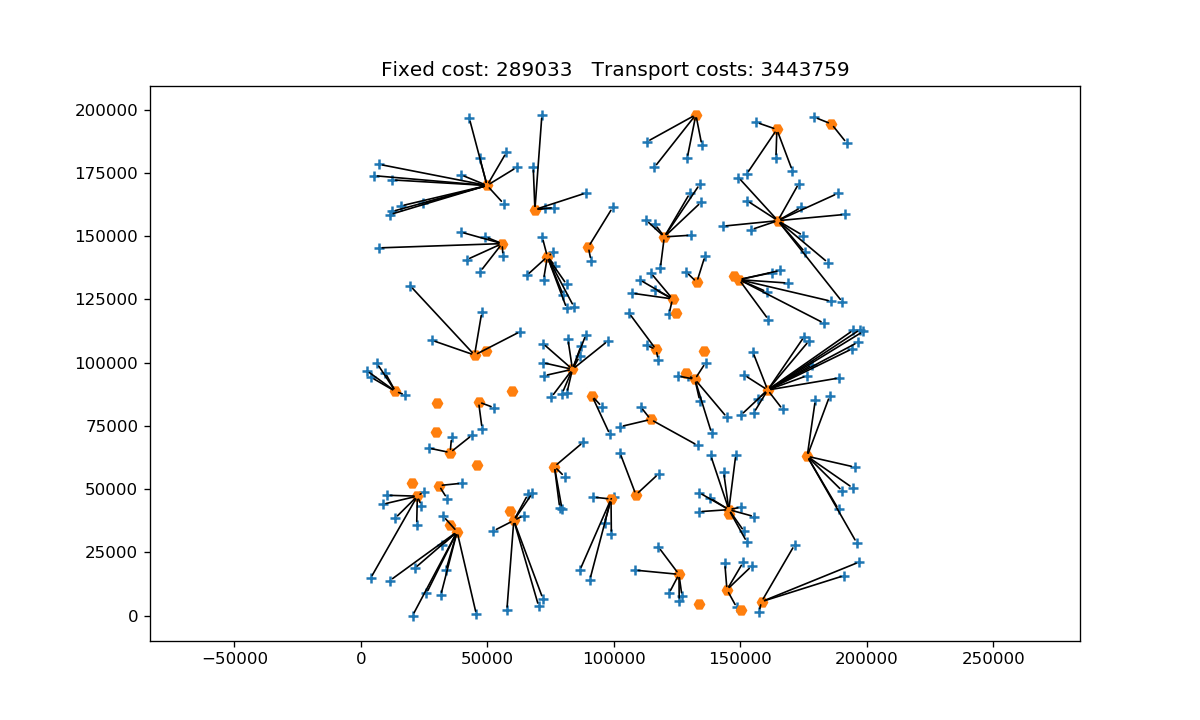

In [40]:
%matplotlib notebook
visualise_solution(data_dict, results_dict)

## Optimal

<IPython.core.display.Javascript object>


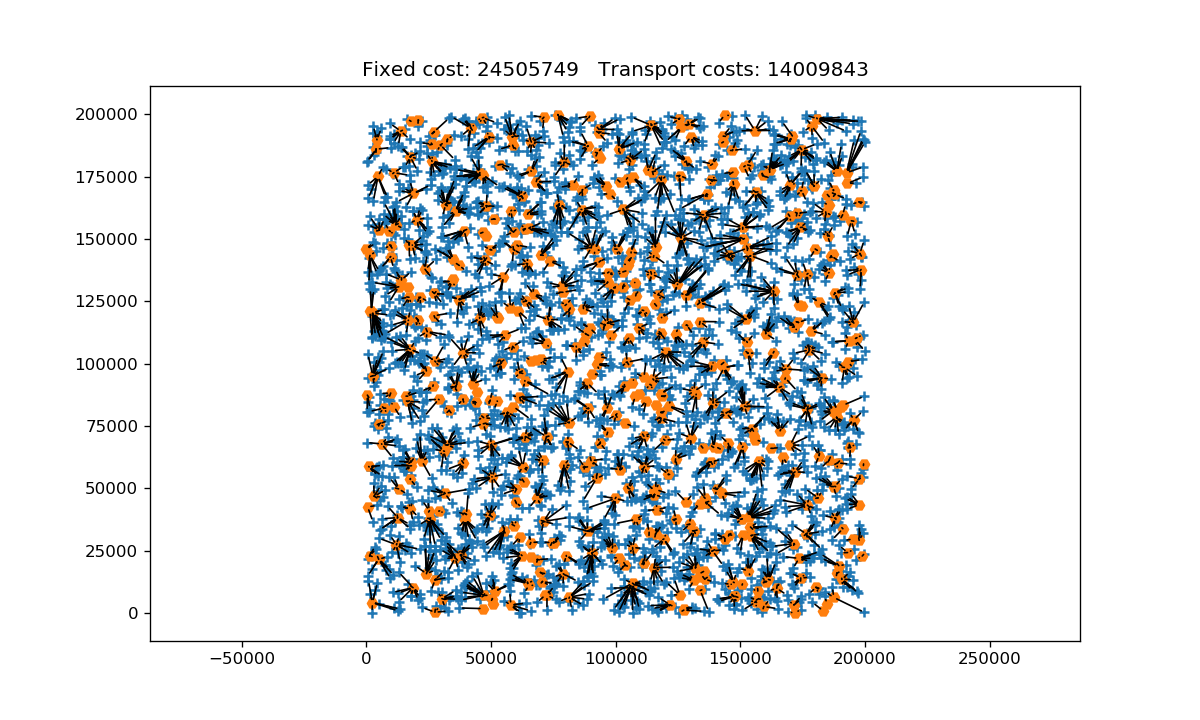

In [98]:
%matplotlib notebook
visualise_solution(data_dict, greedy_results_dict)

## Greedy

### Try a Large Neighbourhood Search algorithm

For a neighbourhood, pick a random part of the map (split it into a grid) and unassign all customers in the grid, as well as all facilities serving these customers and all customers served by those facilities. Solve this subproblem with a IP.

In [33]:
def get_customer_map_corners(customer_location_array):
    
    top_left = [customer_location_array[:,0].min(), customer_location_array[:,1].max()]
    bottom_left = [customer_location_array[:,0].min(), customer_location_array[:,1].min()]
    bottom_right = [customer_location_array[:,0].max(), customer_location_array[:,1].min()]
    top_right = [customer_location_array[:,0].max(), customer_location_array[:,1].max()]
    
    out_dict = {
        'top_left': top_left,
        'bottom_left': bottom_left,
        'bottom_right': bottom_right,
        'top_right': top_right
    }
    
    return out_dict

In [44]:
map_corner_dict = get_customer_map_corners(data_dict['customer_location_array'])
map_corner_dict

{'top_left': [2332.1875, 197932.66],
 'bottom_left': [2332.1875, 0.0],
 'bottom_right': [198625.1425, 0.0],
 'top_right': [198625.1425, 197932.66]}

In [34]:
def interpolate(v1, v2, interp_points, n):
    
    if v1 > v2:
        return v2 + ((v1-v2)/interp_points)*n
    elif v2 > v1:
        return v1 + ((v2-v1)/interp_points)*n
    else:
        return v1

In [18]:
interpolate(10, 20, 10, 11)

21.0

In [35]:
def get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces,
                     central_width_piece_start_num, central_length_piece_start_num, 
                     width_piece_size = 1, length_piece_size = 1):
    
    width_additional_cells = (width_piece_size-1)/2
    length_additional_cells = (length_piece_size-1)/2
    
    x_left = interpolate(map_corner_dict['bottom_left'][0], 
                         map_corner_dict['bottom_right'][0], 
                         num_width_pieces, max(central_width_piece_start_num - width_additional_cells, 0))
    x_right = interpolate(map_corner_dict['bottom_left'][0], 
                          map_corner_dict['bottom_right'][0], 
                          num_width_pieces, min(central_width_piece_start_num + width_additional_cells + 1, 
                                               num_width_pieces))
    y_bottom = interpolate(map_corner_dict['bottom_left'][1], 
                           map_corner_dict['top_left'][1], 
                           num_length_pieces, max(central_length_piece_start_num - length_additional_cells, 0))
    y_top = interpolate(map_corner_dict['bottom_left'][1], 
                        map_corner_dict['top_left'][1], 
                        num_length_pieces, min(central_length_piece_start_num + length_additional_cells + 1, 
                                               num_length_pieces))
    
    out_dict = {
        'top_left': [x_left, y_top],
        'bottom_left': [x_left, y_bottom],
        'bottom_right': [x_right, y_bottom],
        'top_right': [x_right, y_top]
    }
    
    return out_dict

In [48]:
grid_corners = get_grid_corners(map_corner_dict, 10, 10, 5, 5 , width_piece_size = 3, length_piece_size = 3)
grid_corners

{'top_left': [80849.3695, 138552.862],
 'bottom_left': [80849.3695, 79173.064],
 'bottom_right': [139737.256, 79173.064],
 'top_right': [139737.256, 138552.862]}

In [36]:
def get_customers_in_grid(data_dict, grid_corners):
    
    customer_location_array  = data_dict['customer_location_array']
    
    customer_indexes = np.where((customer_location_array[:,0] >= grid_corners['bottom_left'][0])
                               &(customer_location_array[:,0] <= grid_corners['bottom_right'][0])
                               &(customer_location_array[:,1] <= grid_corners['top_left'][1])
                               &(customer_location_array[:,1] >= grid_corners['bottom_left'][1]))[0]
    
    return customer_indexes

In [50]:
get_customers_in_grid(data_dict, grid_corners)

array([  9,  19,  20,  29,  48,  52,  55,  62,  67,  75,  78,  79,  83,
        85,  86,  87,  92, 101, 114, 125, 154, 161, 167, 171, 192],
      dtype=int64)

In [37]:
def get_facilities_in_grid(data_dict, grid_corners):
    
    facility_location_array  = data_dict['facility_location_array']
    
    facility_indexes = np.where((facility_location_array[:,0] >= grid_corners['bottom_left'][0])
                               &(facility_location_array[:,0] <= grid_corners['bottom_right'][0])
                               &(facility_location_array[:,1] <= grid_corners['top_left'][1])
                               &(facility_location_array[:,1] >= grid_corners['bottom_left'][1]))[0]
    
    return facility_indexes

In [54]:
get_facilities_in_grid(data_dict, get_grid_corners(map_corner_dict, 10, 10, 5, 5, 3, 3))

array([ 0,  5,  6, 15, 21, 22, 24, 29, 45], dtype=int64)

In [38]:
def get_remaining_capacity_from_solution(data_dict, solution):
    
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    
    new_capacity_array = facility_capacity_array.copy()
    
    for idx in range(len(solution)):
        facility_index = solution[idx]
        new_capacity_array[facility_index] -= customer_demand_array[idx]
        
    return new_capacity_array

In [60]:
get_remaining_capacity_from_solution(data_dict, solution)

array([4765., 4800., 3596., 3311., 4066., 2666., 3997., 3194., 2715.,
         17., 4167., 4840., 3467., 3158., 3450., 3727., 2783., 5426.,
       3852., 5166., 5302., 4992., 4445., 4483., 1668., 1154., 3707.,
       5514.,  141., 4424., 4905., 1080., 5184., 4117., 3860.,   63.,
       4149., 5329., 1680., 3712., 2720., 2436., 2963., 3157., 2386.,
       3242., 4090., 3367., 5546., 3694.])

In [68]:
data_dict

{'facility_cost_array': array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
         8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
         9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
         8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
         7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
         8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
         8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
         6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
         7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
         9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278]),
 'facility_capacity_array': array([4765., 4800., 5543., 5016., 4924., 4775., 5099., 4879., 5702.,
        6183., 5156., 5699., 3467., 4826., 4522., 4471., 5190., 5426.,
        4633., 6794., 5302., 4992., 4445., 4483., 5686., 5352., 4562.,
        5514., 4065., 5043., 4905., 5580., 5184., 5346.

In [101]:
#def create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array):
    
    new_facility_cost_array = np.zeros(len(facilities_to_include))
    new_facility_capacity_array = np.zeros(len(facilities_to_include))
    
    for counter in range(len(new_facility_cost_array)):
        facility = facilities_to_include[counter]
        new_facility_cost_array[counter] = data_dict['facility_cost_array'][facility]
        if facility in facilities_to_unassign:
            new_facility_capacity_array[counter] = data_dict['facility_capacity_array'][facility]
        else:
            new_facility_capacity_array[counter] = current_remaining_capacity_array[facility]
            
    new_customer_demand_array = np.array([demand for counter, demand in enumerate(data_dict['customer_demand_array'])
                                       if counter in customers_to_unassign])
    
    subproblem_data_dict = {
        'customers_to_unassign': customers_to_unassign,
        'facilities_to_unassign': facilities_to_unassign,
        'facilities_to_include': facilities_to_include,
        'facility_cost_array': new_facility_cost_array,
        'facility_capacity_array': new_facility_capacity_array,
        'customer_demand_array': new_customer_demand_array,
    }
    
    return subproblem_data_dict

In [107]:
#def create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array):
    
    subproblem_data_dict = data_dict.copy()
    
    new_facility_capacity_array = np.zeros(len(facilities_to_include))
    
    for counter in range(len(new_facility_capacity_array)):
        facility = facilities_to_include[counter]
        if facility in facilities_to_unassign:
            new_facility_capacity_array[counter] = data_dict['facility_capacity_array'][facility]
        else:
            new_facility_capacity_array[counter] = current_remaining_capacity_array[facility]
            
    subproblem_data_dict['new_facility_capacity_array'] = new_facility_capacity_array
    
    subproblem_data_dict['customers_to_unassign'] = customers_to_unassign
    subproblem_data_dict['facilities_to_include'] = facilities_to_include
    subproblem_data_dict['facilities_to_unassign'] = facilities_to_unassign

    
    return subproblem_data_dict

In [39]:
def create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array):
    
    subproblem_data_dict = data_dict.copy()
    
    new_facility_capacity_array = current_remaining_capacity_array.copy()
    
    for counter in range(len(current_remaining_capacity_array)):
        if counter in facilities_to_unassign:
            new_facility_capacity_array[counter] = data_dict['facility_capacity_array'][counter]
            
    subproblem_data_dict['new_facility_capacity_array'] = new_facility_capacity_array
    
    subproblem_data_dict['customers_to_unassign'] = customers_to_unassign
    subproblem_data_dict['facilities_to_include'] = facilities_to_include
    subproblem_data_dict['facilities_to_unassign'] = facilities_to_unassign

    
    return subproblem_data_dict

In [189]:
num_width_pieces = 4
num_length_pieces = 4
width_piece_num = 2
length_piece_num = 2

greedy_solution = get_solution(data_dict, greedy_results_dict)
solution = greedy_solution

map_corner_dict = get_customer_map_corners(data_dict['customer_location_array'])
grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                width_piece_num, length_piece_num , width_piece_size = 1, length_piece_size = 1)
initial_customers_to_unassign = get_customers_in_grid(data_dict, grid_corners)
facilities_to_unassign = np.unique(solution[initial_customers_to_unassign])
customers_to_unassign = np.where(np.in1d(solution, facilities_to_unassign))[0]
wider_grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                      width_piece_num, length_piece_num,
                                      width_piece_size = 3, length_piece_size = 3)
facilities_to_include = get_facilities_in_grid(data_dict, wider_grid_corners)
current_remaining_capacity_array = get_remaining_capacity_from_solution(data_dict, solution)

In [140]:
initial_customers_to_unassign

array([  5,  19,  55,  62,  75,  78,  92, 101, 114, 125, 161, 192],
      dtype=int64)

In [141]:
facilities_to_unassign

array([ 5,  6, 15, 21, 22, 44])

In [142]:
facilities_to_include

array([ 0,  5,  6,  8,  9, 10, 11, 13, 14, 15, 16, 21, 22, 24, 29, 31, 37,
       39, 41, 44, 45, 47, 48, 49], dtype=int64)

In [79]:
data_dict['facility_cost_array']

array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
        8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
        9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
        8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
        7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
        8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
        8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
        6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
        7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
        9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278])

In [90]:
data_dict['facility_capacity_array'][facilities_to_include]

array([4765., 4800., 4924., 4775., 5099., 5699., 4522., 4471., 5190.,
       5426., 6794., 4992., 4445., 4483., 5686., 4562., 5514., 4065.,
       5043., 6218., 5329., 5023., 5728., 5431., 5652., 5779., 5546.])

In [85]:
np.sort(np.unique(solution))

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 18, 19, 24,
       25, 26, 28, 29, 31, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47,
       49])

In [102]:
create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array)

{'customers_to_unassign': array([  1,   4,   9,  13,  29,  30,  58,  67,  75,  78,  79,  83,  85,
         86,  96, 101, 115, 152, 167], dtype=int64),
 'facilities_to_unassign': array([ 6, 14, 24, 29]),
 'facilities_to_include': array([ 0,  1,  4,  5,  6, 11, 14, 15, 16, 17, 19, 21, 22, 23, 24, 26, 27,
        28, 29, 34, 37, 39, 41, 44, 45, 47, 48], dtype=int64),
 'facility_cost_array': array([9730.3749, 7582.5512, 7591.9   , 8264.8269, 9295.8959, 8550.8948,
        8918.8834, 8585.5263, 8279.3467, 9233.8784, 6912.127 , 8726.1958,
        8463.1766, 8856.947 , 9532.9436, 9203.9761, 9903.5977, 9367.6393,
        9041.5207, 9422.5489, 7455.7327, 8898.1027, 6667.2292, 7043.196 ,
        9121.5227, 8300.9602, 9613.0121]),
 'facility_capacity_array': array([4765., 4800., 4066., 2666., 5099., 4840., 4522., 3727., 2783.,
        5426., 5166., 4992., 4445., 4483., 5686., 3707., 5514.,  141.,
        5043., 3860., 5329., 3712., 2436., 2386., 3242., 3367., 5546.]),
 'customer_demand_array': arr

In [108]:
create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array)

{'facility_cost_array': array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
         8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
         9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
         8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
         7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
         8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
         8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
         6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
         7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
         9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278]),
 'facility_capacity_array': array([4765., 4800., 5543., 5016., 4924., 4775., 5099., 4879., 5702.,
        6183., 5156., 5699., 3467., 4826., 4522., 4471., 5190., 5426.,
        4633., 6794., 5302., 4992., 4445., 4483., 5686., 5352., 4562.,
        5514., 4065., 5043., 4905., 5580., 5184., 5346.

In [113]:
facilities_to_include

array([ 0,  1,  4,  5,  6, 11, 14, 15, 16, 17, 19, 21, 22, 23, 24, 26, 27,
       28, 29, 34, 37, 39, 41, 44, 45, 47, 48], dtype=int64)

In [114]:
facilities_to_unassign

array([ 6, 14, 24, 29])

In [143]:
subproblem_data_dict = create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array)
subproblem_data_dict

{'facility_cost_array': array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
         8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
         9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
         8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
         7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
         8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
         8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
         6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
         7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
         9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278]),
 'facility_capacity_array': array([4765., 4800., 5543., 5016., 4924., 4775., 5099., 4879., 5702.,
        6183., 5156., 5699., 3467., 4826., 4522., 4471., 5190., 5426.,
        4633., 6794., 5302., 4992., 4445., 4483., 5686., 5352., 4562.,
        5514., 4065., 5043., 4905., 5580., 5184., 5346.

In [40]:
def constraint_fix_open_facilities(model, f):
    
    return model.x[f] == 1

In [41]:
def build_subproblem_model(data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    customers_to_unassign = data_dict['customers_to_unassign']
    facilities_to_unassign = data_dict['facilities_to_unassign']
    facilities_to_include  = data_dict['facilities_to_include']
    facility_cost_array = data_dict['facility_cost_array']
    new_facility_capacity_array = data_dict['new_facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    
    model = pyo.ConcreteModel()
    
    model.F = pyo.Set(initialize=[f for f in facilities_to_include])
    model.F_inc = pyo.Set(initialize=[f for f in facilities_to_include if f not in facilities_to_unassign])
    model.F_unas = pyo.Set(initialize=[f for f in facilities_to_unassign])
    model.C = pyo.Set(initialize=[c for c in customers_to_unassign])
    
    model.fixed_costs = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                  initialize={idx: facility_cost_array[idx] 
                                              for idx in facilities_to_include}, default=0.0)
    model.transport_costs = pyo.Param(model.F, model.C, within=pyo.NonNegativeReals, 
                                      initialize={(facility, customer): facility_customer_dist_matrix[facility, customer] 
                                                  for facility in facilities_to_include
                                                  for customer in customers_to_unassign}, 
                                      default=0.0)
    model.demands = pyo.Param(model.C, within=pyo.NonNegativeReals, 
                              initialize={idx: customer_demand_array[idx] for idx in 
                                          customers_to_unassign}, default=0.0)
    model.capacities = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                 initialize={idx: new_facility_capacity_array[idx] 
                                              for idx in facilities_to_include}, default=0.0)
    
    model.x = pyo.Var(model.F, within=pyo.Binary)
    model.y = pyo.Var(model.F, model.C, within=pyo.Binary)
    
    model.objective_function = pyo.Objective(rule=objective_function, sense=pyo.minimize)
    model.constraint_open_facilities = pyo.Constraint(model.F, model.C, rule=constraint_open_facilities)
    model.constraint_set_open_facilities = pyo.Constraint(model.F_inc, rule=constraint_fix_open_facilities)
    model.constraint_customer_assigned = pyo.Constraint(model.C, rule=constraint_customer_assigned)
    model.constraint_capacity = pyo.Constraint(model.F, rule=constraint_capacity)
    
    return model

In [144]:
subproblem_model_instance = build_subproblem_model(subproblem_data_dict, facility_customer_dist_matrix=None)

In [145]:
subproblem_model_instance, subproblem_results_instance = solve_model_milp(subproblem_model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=120, ratio_gap=0, show_working=True)

Run start time: Wed Feb  5 14:16:57 2020
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Jun 15 2019 

command line - C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe -sec 120 -ratioGap 0 -printingOptions all -import C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmpdbpj8dci.pyomo.lp -stat=1 -solve -solu C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmpdbpj8dci.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 120
ratioGap was changed from 0 to 0
Option for printingOptions changed from normal to all
Presolve 150 (-343) rows, 438 (-19) columns and 1080 (-667) elements
Statistics for presolved model
Original problem has 456 integers (456 of which binary)
Presolved problem has 438 integers (438 of which binary)
==== 0 zero objective 438 different
==== absolute objective values 438 different
==== for integers 0 zero objective 438 different
==== for integers absolute objective values 438 different
===== end objective counts


Problem has 150 rows, 438 colum

In [ ]:
def get_results_dict(model, results, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    out_dict = {'facility_customers':{}}
    fixed_costs = 0
    transport_costs = 0
    
    for tup, val in model.y.get_values().items():
        facility, customer = tup[0], tup[1]
        if val == 1:
            if facility not in out_dict['facility_customers']:
                out_dict['facility_customers'][facility] = [customer]
                fixed_costs += data_dict['facility_cost_array'][facility]
            else:
                out_dict['facility_customers'][facility].append(customer)
            transport_costs += facility_customer_dist_matrix[facility, customer]
            
    if str(list(results['Solver'])[0]['Termination condition']) == 'optimal':
        is_optimal = True
    else:
        is_optimal = False
            
    out_dict['fixed_costs'] = fixed_costs
    out_dict['transport_costs'] = transport_costs
    out_dict['objective_value'] = fixed_costs + transport_costs
    out_dict['is_optimal'] = is_optimal
        
    return out_dict

In [134]:
for tup, val in subproblem_model_instance.y.get_values().items():
    facility, customer = tup[0], tup[1]
    print(facility)
    print(customer)
    print(val)
    print(' ')

0
1
0.0
 
0
4
0.0
 
0
9
0.0
 
0
13
0.0
 
0
29
0.0
 
0
30
0.0
 
0
58
0.0
 
0
67
0.0
 
0
75
0.0
 
0
78
0.0
 
0
79
0.0
 
0
83
0.0
 
0
85
0.0
 
0
86
0.0
 
0
96
0.0
 
0
101
0.0
 
0
115
0.0
 
0
152
0.0
 
0
167
0.0
 
1
1
0.0
 
1
4
0.0
 
1
9
0.0
 
1
13
0.0
 
1
29
0.0
 
1
30
0.0
 
1
58
0.0
 
1
67
0.0
 
1
75
0.0
 
1
78
0.0
 
1
79
0.0
 
1
83
0.0
 
1
85
0.0
 
1
86
0.0
 
1
96
0.0
 
1
101
0.0
 
1
115
0.0
 
1
152
0.0
 
1
167
0.0
 
4
1
0.0
 
4
4
0.0
 
4
9
0.0
 
4
13
0.0
 
4
29
0.0
 
4
30
0.0
 
4
58
0.0
 
4
67
0.0
 
4
75
0.0
 
4
78
0.0
 
4
79
0.0
 
4
83
0.0
 
4
85
0.0
 
4
86
0.0
 
4
96
0.0
 
4
101
0.0
 
4
115
0.0
 
4
152
0.0
 
4
167
0.0
 
5
1
0.0
 
5
4
0.0
 
5
9
0.0
 
5
13
0.0
 
5
29
0.0
 
5
30
0.0
 
5
58
0.0
 
5
67
0.0
 
5
75
0.0
 
5
78
0.0
 
5
79
0.0
 
5
83
0.0
 
5
85
0.0
 
5
86
0.0
 
5
96
0.0
 
5
101
0.0
 
5
115
0.0
 
5
152
0.0
 
5
167
0.0
 
6
1
0.0
 
6
4
0.0
 
6
9
0.0
 
6
13
0.0
 
6
29
0.0
 
6
30
0.0
 
6
58
0.0
 
6
67
0.0
 
6
75
1.0
 
6
78
1.0
 
6
79
0.0
 
6
83
0.0
 
6
85
0.0
 
6
86
0.0
 
6
96
0.0


In [151]:
customers_to_unassign

18

In [146]:
subproblem_results_dict = get_results_dict(subproblem_model_instance, subproblem_results_instance, subproblem_data_dict)
subproblem_results_dict

{'facility_customers': {5: [55, 92, 125, 161, 192],
  6: [75, 78, 101],
  15: [5, 114],
  44: [51, 62, 105, 135, 166, 178, 198],
  45: [19]},
 'fixed_costs': 42310.9678,
 'transport_costs': 212618.6772998851,
 'objective_value': 254929.64509988512,
 'is_optimal': True}

In [164]:
greedy_solution[192]

21

In [42]:
def repair_solution(current_solution, subproblem_data_dict, subproblem_results_dict):
    
    new_solution = current_solution.copy()
    
    customer_to_facility_dict = {i: facility 
                                 for facility, customer_list in subproblem_results_dict['facility_customers'].items()
                                 for i in customer_list}
    
    for customer in subproblem_data_dict['customers_to_unassign']:
        new_solution[customer] = customer_to_facility_dict[customer]
        
    return new_solution

In [190]:
repair_solution(greedy_solution, subproblem_data_dict, subproblem_results_dict)

array([17, 24, 19, 25, 14, 15, 34,  3,  9, 24, 35, 42, 41, 24, 49,  3, 16,
       26, 30, 45,  0, 41,  9, 34,  9, 13, 19,  9, 38, 24, 24,  7,  9, 20,
       31, 33, 28,  9, 28, 25, 38, 40, 35,  7,  2, 23, 27, 25, 41,  9, 34,
       44, 41, 18, 35,  5,  9, 48, 14, 35, 31, 35, 44, 43,  8,  4,  8, 14,
       25,  9, 17, 12, 41, 39, 46,  6,  8, 35,  6, 24, 40, 47, 31, 24, 31,
       24, 24,  0, 34, 16,  7,  2,  5, 39, 20, 35, 24, 40, 31,  3, 47,  6,
       39, 16, 31, 44,  2, 16,  8, 13,  8, 16, 47, 35, 15, 24, 43, 25, 46,
       16, 35, 28, 34, 35, 13,  5,  8, 35, 18, 11, 38, 39, 43, 41, 47, 44,
        9, 41,  9, 38, 38, 28, 23,  9, 28, 17, 42, 41, 47, 16, 35, 32, 29,
        9, 45, 49, 16, 20, 26, 31, 38,  5, 49, 10,  7, 27, 44, 29, 34, 10,
        2, 41, 35, 31, 40, 17, 47, 49, 44, 33,  4,  2, 16, 47, 28,  9,  3,
       31, 11,  9, 31, 25,  5, 42, 13, 31,  8, 40, 44, 45])

In [160]:
d = {i: facility 
     for facility, customer_list in subproblem_results_dict['facility_customers'].items()
     for i in customer_list}
d

{55: 5,
 92: 5,
 125: 5,
 161: 5,
 192: 5,
 75: 6,
 78: 6,
 101: 6,
 5: 15,
 114: 15,
 51: 44,
 62: 44,
 105: 44,
 135: 44,
 166: 44,
 178: 44,
 198: 44,
 19: 45}

In [154]:
subproblem_data_dict

{'facility_cost_array': array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
         8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
         9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
         8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
         7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
         8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
         8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
         6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
         7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
         9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278]),
 'facility_capacity_array': array([4765., 4800., 5543., 5016., 4924., 4775., 5099., 4879., 5702.,
        6183., 5156., 5699., 3467., 4826., 4522., 4471., 5190., 5426.,
        4633., 6794., 5302., 4992., 4445., 4483., 5686., 5352., 4562.,
        5514., 4065., 5043., 4905., 5580., 5184., 5346.

In [149]:
results_dict

{'facility_customers': {2: [44, 91, 106, 170, 181],
  3: [7, 15, 99, 186],
  4: [65, 180],
  5: [55, 92, 125, 161, 192],
  6: [75, 78, 101],
  7: [31, 43, 90, 164],
  8: [27, 66, 76, 110, 126, 153, 196],
  9: [8, 22, 24, 32, 37, 49, 56, 64, 89, 108, 111, 136, 138, 143, 149, 185],
  10: [163, 169],
  11: [129, 188],
  13: [25, 109, 124, 172, 194],
  14: [4, 58, 67],
  15: [5, 114],
  16: [16, 103, 107, 119, 156, 182, 189],
  18: [53, 128],
  19: [2, 26, 45, 142],
  24: [1, 9, 13, 29, 30, 79, 83, 85, 86, 96, 115],
  25: [3, 33, 39, 47, 68, 94, 117, 157, 191],
  26: [17, 158],
  28: [0, 36, 38, 70, 121, 141, 144, 145, 175, 184],
  29: [152, 167],
  31: [34, 57, 60, 82, 84, 98, 104, 159, 173, 187, 190, 195],
  33: [35, 71, 179],
  34: [6, 23, 50, 88, 122, 168],
  35: [10, 42, 54, 59, 61, 77, 95, 113, 120, 123, 127, 150, 176],
  38: [28, 40, 130, 139, 140, 151, 160],
  39: [73, 93, 102, 131],
  40: [41, 46, 80, 97, 165, 174, 197],
  41: [12, 21, 48, 52, 72, 133, 137, 147, 171],
  42: [11, 7

In [147]:
greedy_results_dict

{'facility_customers': {0: [20, 87],
  34: [50, 23, 88, 6, 168, 122],
  30: [18],
  21: [192],
  41: [133, 72, 12, 147, 137, 171, 21, 48, 52],
  38: [40, 160, 28, 130, 139, 140],
  6: [101, 78, 75],
  13: [124, 109, 25, 194],
  2: [181, 44, 106, 170, 91],
  7: [90, 31, 164, 43],
  20: [33, 94, 157],
  40: [197, 174, 41, 97, 80],
  22: [19],
  47: [112, 183, 148, 134, 100, 176, 81],
  28: [121, 38, 184, 141, 36, 144],
  9: [37, 56, 22, 185, 143, 49, 138, 153, 69, 8, 27, 136, 24, 32, 189],
  11: [188, 129],
  39: [131, 102, 93, 73],
  29: [167, 152],
  15: [114, 5],
  24: [83, 29, 85, 1, 13, 86, 30, 96, 79, 115, 9],
  33: [179, 35],
  18: [53, 128],
  44: [105, 135, 178, 62, 51, 166, 198],
  14: [67, 58, 4],
  4: [65, 180],
  12: [71],
  10: [163, 169],
  46: [118, 74],
  5: [55, 125, 92, 161],
  25: [191, 47, 3, 39, 68, 117],
  42: [193, 146, 11],
  49: [14, 162, 155, 177],
  45: [154, 199],
  17: [175, 0, 145, 70],
  35: [61, 120, 77, 10, 150, 54, 59, 95, 172, 127, 123, 42, 113],
  27:

In [99]:
lns_parameter_dict = {
    'num_width_pieces': 10, 
    'num_length_pieces': 10,
    'iterations': 50
}

In [218]:
[(i, j) for i in range(5) for j in range(5)]

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [222]:
def run_lns(data_dict, lns_parameter_dict, initial_sweep = True, initial_solution = None, pprint=False):
    
    
    """
    Run a LNS where the neighbourhood is made by unassigning all the customers in a particular 
    map cell, unassigning all facilities those customers were assigned to, then unassigning 
    all customers assigned to those facilities.
    The subproblem for the neighbourhood only considers the unassigned customers and the
    facilities that were unassigned + the facilities in the neighbouring map cells.
    """
    
    if initial_solution is None:
        #print('ytho')
        initial_solution_results_dict = greedy_algorithm(data_dict)
        initial_solution = get_solution(data_dict, initial_solution_results_dict)
        
    facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    current_solution = initial_solution.copy()
    current_objective = get_objective_value_from_solution(current_solution, data_dict, 
                                                          facility_customer_dist_matrix=facility_customer_dist_matrix)
    
    best_solution = current_solution.copy()
    best_objective = current_objective
    best_remaining_capacity_array = get_remaining_capacity_from_solution(data_dict, best_solution)
    
    if pprint:
        print('starting objective: ' + str(best_objective))
        
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    num_width_pieces = lns_parameter_dict['num_width_pieces']
    num_length_pieces = lns_parameter_dict['num_length_pieces']
    iterations = lns_parameter_dict['iterations']
    
    map_corner_dict = get_customer_map_corners(customer_location_array)
    
    if initial_sweep:
        initial_sweep_list = [(i, j) for i in range(num_width_pieces) for j in range(num_length_pieces)]
        iterations = max(iterations, num_width_pieces*num_length_pieces)
    
    for iteration in range(iterations):
        if pprint:
            print('iteration ' + str(iteration))
        if initial_sweep and iteration < num_width_pieces*num_length_pieces:
            # if we're doing an initial sweet first use those values
            width_piece_num, length_piece_num = initial_sweep_list[iteration][0], initial_sweep_list[iteration][1]
        else:
            # pick a random square on the grid to optimise
            width_piece_num, length_piece_num = np.random.randint(num_width_pieces), np.random.randint(num_length_pieces)
        grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                        width_piece_num, length_piece_num)
        if pprint:
            print((width_piece_num, length_piece_num))
        # get the customers to initially unassign, and the facilities they were assigned to,
        # then get all the customers for those facilities to unassign
        # then get all the facilities in the 8 grid cells surrounding the current 
        # grid cell to include in the subproblem
        initial_customers_to_unassign = get_customers_in_grid(data_dict, grid_corners)
        facilities_to_unassign = np.unique(current_solution[initial_customers_to_unassign])
        customers_to_unassign = np.where(np.in1d(current_solution, facilities_to_unassign))[0]
        wider_grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                              width_piece_num, length_piece_num,
                                              width_piece_size = 3, length_piece_size = 3)
        facilities_to_include = get_facilities_in_grid(data_dict, wider_grid_corners)
        # calculate the new capacities for the facilities in the wider grid 
        # that still have some customers assigned, then create a new data 
        # dict for the subproblem
        current_remaining_capacity_array = get_remaining_capacity_from_solution(data_dict, current_solution)
        subproblem_data_dict = create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                                           facilities_to_include, current_remaining_capacity_array)
        #if pprint:
        #    print(subproblem_data_dict)
        subproblem_model_instance = build_subproblem_model(subproblem_data_dict, 
                                                           facility_customer_dist_matrix=facility_customer_dist_matrix)
        subproblem_model_instance, subproblem_results_instance = solve_model_milp(subproblem_model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=120, ratio_gap=0, show_working=False)
        subproblem_results_dict = get_results_dict(subproblem_model_instance, 
                                                   subproblem_results_instance, 
                                                   subproblem_data_dict)
        #if pprint:
        #    print(subproblem_data_dict)
        new_solution = repair_solution(current_solution, subproblem_data_dict, subproblem_results_dict)
        new_objective = get_objective_value_from_solution(new_solution, data_dict)
        if pprint:
            print('new objective_value: ' + str(new_objective))
        if new_objective < current_objective:
            current_solution = new_solution
            current_objective = new_objective
            if new_objective < best_objective:
                best_solution = new_solution
                best_objective = new_objective
                print('best objective updated')
        if pprint:
            print(' ')
            
    out_dict = {
        'solution_array': best_solution,
        'objective_value': best_objective
    }
                
    return out_dict
        
        

In [101]:
def run_lns(data_dict, lns_parameter_dict, objective_to_beat, initial_sweep = True, initial_solution = None, pprint=False):
    
    
    """
    Run a LNS where the neighbourhood is made by unassigning all the customers in a particular 
    map cell, unassigning all facilities those customers were assigned to, then unassigning 
    all customers assigned to those facilities.
    The subproblem for the neighbourhood only considers the unassigned customers and the
    facilities that were unassigned + the facilities in the neighbouring map cells.
    """
    
    if initial_solution is None:
        #print('ytho')
        initial_solution_results_dict = greedy_algorithm(data_dict)
        initial_solution = get_solution(data_dict, initial_solution_results_dict)
        
    facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    current_solution = initial_solution.copy()
    current_objective = get_objective_value_from_solution(current_solution, data_dict, 
                                                          facility_customer_dist_matrix=facility_customer_dist_matrix)
    
    best_solution = current_solution.copy()
    best_objective = current_objective
    best_remaining_capacity_array = get_remaining_capacity_from_solution(data_dict, best_solution)
    
    if pprint:
        print('starting objective: ' + str(best_objective))
        
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    num_width_pieces = lns_parameter_dict['num_width_pieces']
    num_length_pieces = lns_parameter_dict['num_length_pieces']
    iterations = lns_parameter_dict['iterations']
    
    map_corner_dict = get_customer_map_corners(customer_location_array)
    
    if initial_sweep:
        initial_sweep_list = [(i, j) for i in range(num_width_pieces) for j in range(num_length_pieces)]
        iterations = max(iterations, num_width_pieces*num_length_pieces)
    
    iteration = 0
    while best_objective > objective_to_beat:
        if pprint:
            print('iteration ' + str(iteration))
        if initial_sweep and iteration < num_width_pieces*num_length_pieces:
            # if we're doing an initial sweet first use those values
            width_piece_num, length_piece_num = initial_sweep_list[iteration][0], initial_sweep_list[iteration][1]
        else:
            # pick a random square on the grid to optimise
            #width_piece_num, length_piece_num = np.random.randint(num_width_pieces), np.random.randint(num_length_pieces)
            width_piece_num  = np.random.rand()*(num_width_pieces-1)
            length_piece_num = np.random.rand()*(num_length_pieces-1)
        grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                        width_piece_num, length_piece_num)
        if pprint:
            print((width_piece_num, length_piece_num))
        # get the customers to initially unassign, and the facilities they were assigned to,
        # then get all the customers for those facilities to unassign
        # then get all the facilities in the 8 grid cells surrounding the current 
        # grid cell to include in the subproblem
        initial_customers_to_unassign = get_customers_in_grid(data_dict, grid_corners)
        facilities_to_unassign = np.unique(current_solution[initial_customers_to_unassign])
        customers_to_unassign = np.where(np.in1d(current_solution, facilities_to_unassign))[0]
        wider_grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                              width_piece_num, length_piece_num,
                                              width_piece_size = 5, length_piece_size = 5)
        facilities_to_include = get_facilities_in_grid(data_dict, wider_grid_corners)
        # calculate the new capacities for the facilities in the wider grid 
        # that still have some customers assigned, then create a new data 
        # dict for the subproblem
        current_remaining_capacity_array = get_remaining_capacity_from_solution(data_dict, current_solution)
        subproblem_data_dict = create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                                           facilities_to_include, current_remaining_capacity_array)
        #if pprint:
        #    print(subproblem_data_dict)
        subproblem_model_instance = build_subproblem_model(subproblem_data_dict, 
                                                           facility_customer_dist_matrix=facility_customer_dist_matrix)
        subproblem_model_instance, subproblem_results_instance = solve_model_milp(subproblem_model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=120, ratio_gap=0, show_working=False)
        #subproblem_model_instance, subproblem_results_instance = solve_model_milp(subproblem_model_instance, 'cplex', 
         #                                           'neos',
         #                                           timeout_time=120, ratio_gap=0, show_working=False)
        subproblem_results_dict = get_results_dict(subproblem_model_instance, 
                                                   subproblem_results_instance, 
                                                   subproblem_data_dict)
        #if pprint:
        #    print(subproblem_data_dict)
        new_solution = repair_solution(current_solution, subproblem_data_dict, subproblem_results_dict)
        new_objective = get_objective_value_from_solution(new_solution, data_dict)
        if pprint:
            print('new objective_value: ' + str(new_objective))
            
        if new_objective < current_objective:
            current_solution = new_solution
            current_objective = new_objective
            if new_objective < best_objective:
                best_solution = new_solution
                best_objective = new_objective
                print('BEST OBJECTIVE VALUE UPDATED')
        if pprint:
            print('best objective_value: ' + str(best_objective))
            print(' ')
        iteration += 1
            
    out_dict = {
        'solution_array': best_solution,
        'objective_value': best_objective
    }
                
    return out_dict
        
        

In [20]:
np.random.randint(5)

4

In [68]:
10275002.138018716

4.023703923737016

In [73]:
lns_dict = run_lns(data_dict, lns_parameter_dict, 10000000, initial_sweep = True, 
                   initial_solution = None, pprint=True)
lns_dict

starting objective: 11927977.23547606
iteration 0
(0, 0)
Run start time: Thu Feb  6 10:16:10 2020
Run finish time: Thu Feb  6 10:16:11 2020
new objective_value: 11884151.961716503
BEST OBJECTIVE VALUE UPDATED
best objective_value: 11884151.961716503
 
iteration 1
(0, 1)
Run start time: Thu Feb  6 10:16:12 2020
Run finish time: Thu Feb  6 10:16:12 2020
new objective_value: 11873080.834147159
BEST OBJECTIVE VALUE UPDATED
best objective_value: 11873080.834147159
 
iteration 2
(0, 2)
Run start time: Thu Feb  6 10:16:14 2020
Run finish time: Thu Feb  6 10:16:14 2020
new objective_value: 11898922.16343691
best objective_value: 11873080.834147159
 
iteration 3
(0, 3)
Run start time: Thu Feb  6 10:16:15 2020
Run finish time: Thu Feb  6 10:16:16 2020
new objective_value: 11798762.508790832
BEST OBJECTIVE VALUE UPDATED
best objective_value: 11798762.508790832
 
iteration 4
(0, 4)
Run start time: Thu Feb  6 10:16:17 2020
Run finish time: Thu Feb  6 10:16:18 2020
new objective_value: 11766064.1026

Run start time: Thu Feb  6 10:17:30 2020
Run finish time: Thu Feb  6 10:17:31 2020
new objective_value: 11098970.262814768
best objective_value: 11081201.70340807
 
iteration 41
(5, 1)
Run start time: Thu Feb  6 10:17:32 2020
Run finish time: Thu Feb  6 10:17:33 2020
new objective_value: 11061192.517789684
BEST OBJECTIVE VALUE UPDATED
best objective_value: 11061192.517789684
 
iteration 42
(5, 2)
Run start time: Thu Feb  6 10:17:34 2020
Run finish time: Thu Feb  6 10:17:35 2020
new objective_value: 11034560.636136197
BEST OBJECTIVE VALUE UPDATED
best objective_value: 11034560.636136197
 
iteration 43
(5, 3)
Run start time: Thu Feb  6 10:17:36 2020
Run finish time: Thu Feb  6 10:17:38 2020
new objective_value: 10988351.26809288
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10988351.26809288
 
iteration 44
(5, 4)
Run start time: Thu Feb  6 10:17:39 2020
Run finish time: Thu Feb  6 10:17:41 2020
new objective_value: 10998154.089306187
best objective_value: 10988351.26809288
 
iterati

Run start time: Thu Feb  6 10:18:49 2020
Run finish time: Thu Feb  6 10:18:50 2020
new objective_value: 10486126.091460453
best objective_value: 10450807.781898325
 
iteration 80
(6.425780953510573, 0.6928645177232579)
Run start time: Thu Feb  6 10:18:51 2020
Run finish time: Thu Feb  6 10:18:52 2020
new objective_value: 10505150.371932752
best objective_value: 10450807.781898325
 
iteration 81
(4.544263360350963, 1.053746754049333)
Run start time: Thu Feb  6 10:18:52 2020
Run finish time: Thu Feb  6 10:18:54 2020
new objective_value: 10440534.73328661
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10440534.73328661
 
iteration 82
(2.6286135690350285, 0.38309017009253166)
Run start time: Thu Feb  6 10:18:55 2020
Run finish time: Thu Feb  6 10:18:56 2020
new objective_value: 10440408.697008502
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10440408.697008502
 
iteration 83
(2.8327505365636503, 5.03064190242439)
Run start time: Thu Feb  6 10:18:57 2020
Run finish time: Thu Feb  6

Run start time: Thu Feb  6 10:20:12 2020
Run finish time: Thu Feb  6 10:20:13 2020
new objective_value: 10447050.080719102
best objective_value: 10423108.64607523
 
iteration 117
(1.521638087592495, 0.3654171828204088)
Run start time: Thu Feb  6 10:20:14 2020
Run finish time: Thu Feb  6 10:20:15 2020
new objective_value: 10440169.169372384
best objective_value: 10423108.64607523
 
iteration 118
(6.914154596617442, 1.8346953851689922)
Run start time: Thu Feb  6 10:20:15 2020
Run finish time: Thu Feb  6 10:20:17 2020
new objective_value: 10460306.015376393
best objective_value: 10423108.64607523
 
iteration 119
(0.43439010873797523, 3.509184554361742)
Run start time: Thu Feb  6 10:20:18 2020
Run finish time: Thu Feb  6 10:20:19 2020
new objective_value: 10470461.108329521
best objective_value: 10423108.64607523
 
iteration 120
(6.089308921985366, 3.1914364961801325)
Run start time: Thu Feb  6 10:20:20 2020
Run finish time: Thu Feb  6 10:20:21 2020
new objective_value: 10448801.52796517
b

Run finish time: Thu Feb  6 10:21:25 2020
new objective_value: 10418332.6186315
best objective_value: 10402706.844671305
 
iteration 154
(6.344487103245184, 1.0534877349239062)
Run start time: Thu Feb  6 10:21:26 2020
Run finish time: Thu Feb  6 10:21:26 2020
new objective_value: 10457667.69569497
best objective_value: 10402706.844671305
 
iteration 155
(6.890807354826308, 6.875596886897254)
Run start time: Thu Feb  6 10:21:27 2020
Run finish time: Thu Feb  6 10:21:27 2020
new objective_value: 10456361.793145277
best objective_value: 10402706.844671305
 
iteration 156
(1.457259713333301, 5.202660421596914)
Run start time: Thu Feb  6 10:21:28 2020
Run finish time: Thu Feb  6 10:21:29 2020
new objective_value: 10370056.061628886
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10370056.061628886
 
iteration 157
(0.7580828455844971, 0.24721101825484604)
Run start time: Thu Feb  6 10:21:30 2020
Run finish time: Thu Feb  6 10:21:31 2020
new objective_value: 10393181.350351304
best objecti

Run finish time: Thu Feb  6 10:22:38 2020
new objective_value: 10367129.77318638
best objective_value: 10348776.18958252
 
iteration 191
(4.020104697818939, 5.020585824801208)
Run start time: Thu Feb  6 10:22:39 2020
Run finish time: Thu Feb  6 10:22:40 2020
new objective_value: 10376090.482313322
best objective_value: 10348776.18958252
 
iteration 192
(0.3603964373870543, 5.282435620280966)
Run start time: Thu Feb  6 10:22:41 2020
Run finish time: Thu Feb  6 10:22:42 2020
new objective_value: 10396142.082096525
best objective_value: 10348776.18958252
 
iteration 193
(3.967121858893175, 4.006652717698496)
Run start time: Thu Feb  6 10:22:42 2020
Run finish time: Thu Feb  6 10:22:44 2020
new objective_value: 10382022.37457877
best objective_value: 10348776.18958252
 
iteration 194
(6.165003166789408, 4.186551790637852)
Run start time: Thu Feb  6 10:22:45 2020
Run finish time: Thu Feb  6 10:22:46 2020
new objective_value: 10364808.60703973
best objective_value: 10348776.18958252
 
iterat

Run start time: Thu Feb  6 10:23:54 2020
Run finish time: Thu Feb  6 10:23:56 2020
new objective_value: 10373101.235513717
best objective_value: 10347595.90826232
 
iteration 229
(4.026982422793446, 2.031171312809857)
Run start time: Thu Feb  6 10:23:57 2020
Run finish time: Thu Feb  6 10:23:59 2020
new objective_value: 10360233.44414209
best objective_value: 10347595.90826232
 
iteration 230
(0.8850647818001122, 1.3102486527550776)
Run start time: Thu Feb  6 10:23:59 2020
Run finish time: Thu Feb  6 10:24:00 2020
new objective_value: 10405493.16687255
best objective_value: 10347595.90826232
 
iteration 231
(4.127954082416192, 5.076155646129141)
Run start time: Thu Feb  6 10:24:00 2020
Run finish time: Thu Feb  6 10:24:02 2020
new objective_value: 10374494.51079965
best objective_value: 10347595.90826232
 
iteration 232
(5.303060694125213, 2.8121686054380812)
Run start time: Thu Feb  6 10:24:03 2020
Run finish time: Thu Feb  6 10:24:05 2020
new objective_value: 10367797.669985883
best 

Run start time: Thu Feb  6 10:25:12 2020
Run finish time: Thu Feb  6 10:25:13 2020
new objective_value: 10285094.203808233
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10285094.203808233
 
iteration 266
(5.277058641268708, 4.129435077015991)
Run start time: Thu Feb  6 10:25:14 2020
Run finish time: Thu Feb  6 10:25:16 2020
new objective_value: 10273991.670960506
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10273991.670960506
 
iteration 267
(5.200374517712669, 4.581139335397463)
Run start time: Thu Feb  6 10:25:17 2020
Run finish time: Thu Feb  6 10:25:20 2020
new objective_value: 10305684.45006929
best objective_value: 10273991.670960506
 
iteration 268
(1.6853790833952176, 2.381180692570431)
Run start time: Thu Feb  6 10:25:20 2020
Run finish time: Thu Feb  6 10:25:22 2020
new objective_value: 10300593.302266855
best objective_value: 10273991.670960506
 
iteration 269
(4.623104953873139, 0.49778229314700917)
Run start time: Thu Feb  6 10:25:22 2020
Run finish time: Thu Fe

Run start time: Thu Feb  6 10:26:36 2020
Run finish time: Thu Feb  6 10:26:40 2020
new objective_value: 10262550.075681258
best objective_value: 10261328.192226434
 
iteration 303
(0.4166097686893916, 3.2684211632613955)
Run start time: Thu Feb  6 10:26:41 2020
Run finish time: Thu Feb  6 10:26:45 2020
new objective_value: 10292671.734556772
best objective_value: 10261328.192226434
 
iteration 304
(3.8050239342122403, 0.011557359253319577)
Run start time: Thu Feb  6 10:26:46 2020
Run finish time: Thu Feb  6 10:26:50 2020
new objective_value: 10295355.858782768
best objective_value: 10261328.192226434
 
iteration 305
(0.22758451207084052, 2.8545038582510642)
Run start time: Thu Feb  6 10:26:51 2020
Run finish time: Thu Feb  6 10:26:56 2020
new objective_value: 10311291.234725509
best objective_value: 10261328.192226434
 
iteration 306
(5.509545785623225, 2.162009150947176)
Run start time: Thu Feb  6 10:26:58 2020
Run finish time: Thu Feb  6 10:27:02 2020
new objective_value: 10270328.62

Run start time: Thu Feb  6 10:29:34 2020
Run finish time: Thu Feb  6 10:29:36 2020
new objective_value: 10315960.55886845
best objective_value: 10239546.939808745
 
iteration 340
(3.1198883843190703, 1.2081280312503766)
Run start time: Thu Feb  6 10:29:38 2020
Run finish time: Thu Feb  6 10:29:40 2020
new objective_value: 10280732.78348482
best objective_value: 10239546.939808745
 
iteration 341
(4.82541755079209, 4.711160527035456)
Run start time: Thu Feb  6 10:29:41 2020
Run finish time: Thu Feb  6 10:29:45 2020
new objective_value: 10262907.329261282
best objective_value: 10239546.939808745
 
iteration 342
(5.54084760272122, 0.6571770967017145)
Run start time: Thu Feb  6 10:29:47 2020
Run finish time: Thu Feb  6 10:29:50 2020
new objective_value: 10264967.71952482
best objective_value: 10239546.939808745
 
iteration 343
(1.8474179568275488, 5.895728029940011)
Run start time: Thu Feb  6 10:29:51 2020
Run finish time: Thu Feb  6 10:29:53 2020
new objective_value: 10258227.433858784
be

Run start time: Thu Feb  6 10:32:32 2020
Run finish time: Thu Feb  6 10:32:35 2020
new objective_value: 10244462.649969004
best objective_value: 10219777.081411235
 
iteration 377
(4.547799684800943, 2.3625371011821525)
Run start time: Thu Feb  6 10:32:37 2020
Run finish time: Thu Feb  6 10:32:42 2020
new objective_value: 10299404.355890185
best objective_value: 10219777.081411235
 
iteration 378
(4.824675585822288, 1.2764534277173956)
Run start time: Thu Feb  6 10:32:44 2020
Run finish time: Thu Feb  6 10:32:47 2020
new objective_value: 10258709.041084265
best objective_value: 10219777.081411235
 
iteration 379
(3.450260436717918, 4.812956735143621)
Run start time: Thu Feb  6 10:32:49 2020
Run finish time: Thu Feb  6 10:32:53 2020
new objective_value: 10242155.746719327
best objective_value: 10219777.081411235
 
iteration 380
(6.656180924396143, 6.576551647825679)
Run start time: Thu Feb  6 10:32:55 2020
Run finish time: Thu Feb  6 10:32:58 2020
new objective_value: 10248472.082648527

Run start time: Thu Feb  6 10:35:34 2020
Run finish time: Thu Feb  6 10:35:36 2020
new objective_value: 10262148.114752702
best objective_value: 10217720.41716474
 
iteration 415
(1.8718137763890361, 3.7692693329678897)
Run start time: Thu Feb  6 10:35:38 2020
Run finish time: Thu Feb  6 10:35:41 2020
new objective_value: 10253761.636437254
best objective_value: 10217720.41716474
 
iteration 416
(1.4326083949906914, 6.799522597303731)
Run start time: Thu Feb  6 10:35:43 2020
Run finish time: Thu Feb  6 10:35:47 2020
new objective_value: 10231507.355121482
best objective_value: 10217720.41716474
 
iteration 417
(0.8646104635349177, 5.3037252349049755)
Run start time: Thu Feb  6 10:35:48 2020
Run finish time: Thu Feb  6 10:35:51 2020
new objective_value: 10250291.474682275
best objective_value: 10217720.41716474
 
iteration 418
(2.3936330825706253, 4.5669752944919795)
Run start time: Thu Feb  6 10:35:53 2020
Run finish time: Thu Feb  6 10:35:57 2020
new objective_value: 10262924.36509603

Run start time: Thu Feb  6 10:39:00 2020
Run finish time: Thu Feb  6 10:39:05 2020
new objective_value: 10250472.468178637
best objective_value: 10204993.142663682
 
iteration 453
(3.20821441925853, 0.8253760988446949)
Run start time: Thu Feb  6 10:39:06 2020
Run finish time: Thu Feb  6 10:39:11 2020
new objective_value: 10238398.118987612
best objective_value: 10204993.142663682
 
iteration 454
(3.509370384222073, 5.186207685552763)
Run start time: Thu Feb  6 10:39:13 2020
Run finish time: Thu Feb  6 10:39:18 2020
new objective_value: 10222782.913036574
best objective_value: 10204993.142663682
 
iteration 455
(3.2275144045366857, 0.3075433668334884)
Run start time: Thu Feb  6 10:39:19 2020
Run finish time: Thu Feb  6 10:39:24 2020
new objective_value: 10228948.004301045
best objective_value: 10204993.142663682
 
iteration 456
(5.695848892448111, 4.957733370502106)
Run start time: Thu Feb  6 10:39:25 2020
Run finish time: Thu Feb  6 10:39:30 2020
new objective_value: 10216037.961612996

Run finish time: Thu Feb  6 10:42:28 2020
new objective_value: 10209315.904297283
best objective_value: 10192319.598773263
 
iteration 490
(5.895428995970821, 0.2515063357255696)
Run start time: Thu Feb  6 10:42:29 2020
Run finish time: Thu Feb  6 10:42:33 2020
new objective_value: 10221663.445718542
best objective_value: 10192319.598773263
 
iteration 491
(5.439947883948665, 1.994956174095062)
Run start time: Thu Feb  6 10:42:36 2020
Run finish time: Thu Feb  6 10:42:40 2020
new objective_value: 10233631.667956065
best objective_value: 10192319.598773263
 
iteration 492
(4.3107875241492914, 3.5816403802013332)
Run start time: Thu Feb  6 10:42:42 2020
Run finish time: Thu Feb  6 10:42:47 2020
new objective_value: 10222301.767550584
best objective_value: 10192319.598773263
 
iteration 493
(1.7414430348809105, 0.8485430636772835)
Run start time: Thu Feb  6 10:42:49 2020
Run finish time: Thu Feb  6 10:42:53 2020
new objective_value: 10195736.924243348
best objective_value: 10192319.598773

Run start time: Thu Feb  6 10:45:41 2020
Run finish time: Thu Feb  6 10:45:44 2020
new objective_value: 10233182.874178024
best objective_value: 10192319.598773263
 
iteration 528
(0.5024198624502448, 3.077678004866787)
Run start time: Thu Feb  6 10:45:45 2020
Run finish time: Thu Feb  6 10:45:49 2020
new objective_value: 10239930.957584929
best objective_value: 10192319.598773263
 
iteration 529
(3.1021568471201064, 4.788699515555421)
Run start time: Thu Feb  6 10:45:51 2020
Run finish time: Thu Feb  6 10:45:55 2020
new objective_value: 10233664.628602
best objective_value: 10192319.598773263
 
iteration 530
(3.592607214712961, 1.6656535214597374)
Run start time: Thu Feb  6 10:45:56 2020
Run finish time: Thu Feb  6 10:46:00 2020
new objective_value: 10216651.821890634
best objective_value: 10192319.598773263
 
iteration 531
(1.646673189172685, 6.0328040096834314)
Run start time: Thu Feb  6 10:46:01 2020
Run finish time: Thu Feb  6 10:46:05 2020
new objective_value: 10219508.40165431
b

Run finish time: Thu Feb  6 10:48:48 2020
new objective_value: 10208439.359123746
best objective_value: 10177844.149079435
 
iteration 565
(1.3614839473604068, 2.68632234013695)
Run start time: Thu Feb  6 10:48:49 2020
Run finish time: Thu Feb  6 10:48:53 2020
new objective_value: 10195805.457383482
best objective_value: 10177844.149079435
 
iteration 566
(3.4414647450380498, 5.910873474409083)
Run start time: Thu Feb  6 10:48:56 2020
Run finish time: Thu Feb  6 10:48:59 2020
new objective_value: 10224361.72045784
best objective_value: 10177844.149079435
 
iteration 567
(3.231601831675319, 5.491922640620452)
Run start time: Thu Feb  6 10:49:02 2020
Run finish time: Thu Feb  6 10:49:06 2020
new objective_value: 10231968.069366958
best objective_value: 10177844.149079435
 
iteration 568
(6.592880597059212, 3.306878840748883)
Run start time: Thu Feb  6 10:49:07 2020
Run finish time: Thu Feb  6 10:49:09 2020
new objective_value: 10201482.08678993
best objective_value: 10177844.149079435
 


Run finish time: Thu Feb  6 10:51:53 2020
new objective_value: 10200661.916371161
best objective_value: 10171663.031644832
 
iteration 602
(3.4261134544567686, 0.6499490661265762)
Run start time: Thu Feb  6 10:51:55 2020
Run finish time: Thu Feb  6 10:52:05 2020
new objective_value: 10171902.441325743
best objective_value: 10171663.031644832
 
iteration 603
(1.911733629403573, 1.8526349829107651)
Run start time: Thu Feb  6 10:52:07 2020
Run finish time: Thu Feb  6 10:52:12 2020
new objective_value: 10165109.86074854
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10165109.86074854
 
iteration 604
(4.498227217944252, 6.975261905771974)
Run start time: Thu Feb  6 10:52:13 2020
Run finish time: Thu Feb  6 10:52:16 2020
new objective_value: 10221512.853040263
best objective_value: 10165109.86074854
 
iteration 605
(1.2963989824281565, 4.678129978661361)
Run start time: Thu Feb  6 10:52:18 2020
Run finish time: Thu Feb  6 10:52:22 2020
new objective_value: 10235103.89195413
best objectiv

Run start time: Thu Feb  6 10:55:13 2020
Run finish time: Thu Feb  6 10:55:16 2020
new objective_value: 10209832.704425553
best objective_value: 10165109.86074854
 
iteration 640
(3.5521643715577653, 6.011135403948853)
Run start time: Thu Feb  6 10:55:19 2020
Run finish time: Thu Feb  6 10:55:24 2020
new objective_value: 10219078.296331704
best objective_value: 10165109.86074854
 
iteration 641
(3.7420573062422493, 1.5977032602491603)
Run start time: Thu Feb  6 10:55:25 2020
Run finish time: Thu Feb  6 10:55:28 2020
new objective_value: 10186383.450049121
best objective_value: 10165109.86074854
 
iteration 642
(2.4144351403715367, 5.619839491343725)
Run start time: Thu Feb  6 10:55:30 2020
Run finish time: Thu Feb  6 10:55:34 2020
new objective_value: 10214071.39562138
best objective_value: 10165109.86074854
 
iteration 643
(6.220648234909364, 6.495979997682496)
Run start time: Thu Feb  6 10:55:35 2020
Run finish time: Thu Feb  6 10:55:39 2020
new objective_value: 10184366.717140866
be

Run finish time: Thu Feb  6 10:58:05 2020
new objective_value: 10161332.251893217
best objective_value: 10150298.307747534
 
iteration 677
(2.530369144210721, 6.498179960964195)
Run start time: Thu Feb  6 10:58:05 2020
Run finish time: Thu Feb  6 10:58:07 2020
new objective_value: 10200740.13815988
best objective_value: 10150298.307747534
 
iteration 678
(3.3412753021102484, 1.6367899839667917)
Run start time: Thu Feb  6 10:58:08 2020
Run finish time: Thu Feb  6 10:58:09 2020
new objective_value: 10157395.803347753
best objective_value: 10150298.307747534
 
iteration 679
(0.4495503938618387, 2.7538593504865525)
Run start time: Thu Feb  6 10:58:10 2020
Run finish time: Thu Feb  6 10:58:11 2020
new objective_value: 10189885.295321995
best objective_value: 10150298.307747534
 
iteration 680
(5.0094390392414425, 1.3795273878194125)
Run start time: Thu Feb  6 10:58:11 2020
Run finish time: Thu Feb  6 10:58:13 2020
new objective_value: 10181632.25436835
best objective_value: 10150298.3077475

Run start time: Thu Feb  6 10:59:32 2020
Run finish time: Thu Feb  6 10:59:34 2020
new objective_value: 10204992.362188097
best objective_value: 10134998.330982506
 
iteration 715
(1.3499429272418637, 0.16922290697622266)
Run start time: Thu Feb  6 10:59:35 2020
Run finish time: Thu Feb  6 10:59:36 2020
new objective_value: 10143388.786046807
best objective_value: 10134998.330982506
 
iteration 716
(6.94933667330099, 4.102895219761695)
Run start time: Thu Feb  6 10:59:36 2020
Run finish time: Thu Feb  6 10:59:37 2020
new objective_value: 10142997.300902601
best objective_value: 10134998.330982506
 
iteration 717
(4.372544623712045, 1.936287343382887)
Run start time: Thu Feb  6 10:59:38 2020
Run finish time: Thu Feb  6 10:59:40 2020
new objective_value: 10186744.824300746
best objective_value: 10134998.330982506
 
iteration 718
(6.66604447722841, 4.226316026737812)
Run start time: Thu Feb  6 10:59:40 2020
Run finish time: Thu Feb  6 10:59:41 2020
new objective_value: 10128504.19648451
B

Run start time: Thu Feb  6 11:00:54 2020
Run finish time: Thu Feb  6 11:00:55 2020
new objective_value: 10152251.259248415
best objective_value: 10128504.19648451
 
iteration 753
(3.694670144534266, 5.973054255388458)
Run start time: Thu Feb  6 11:00:56 2020
Run finish time: Thu Feb  6 11:00:59 2020
new objective_value: 10174098.941740308
best objective_value: 10128504.19648451
 
iteration 754
(0.24271337940096727, 5.526307624080262)
Run start time: Thu Feb  6 11:00:59 2020
Run finish time: Thu Feb  6 11:01:00 2020
new objective_value: 10180496.205088068
best objective_value: 10128504.19648451
 
iteration 755
(5.852751464654213, 1.4749990844169807)
Run start time: Thu Feb  6 11:01:02 2020
Run finish time: Thu Feb  6 11:01:04 2020
new objective_value: 10187838.856244678
best objective_value: 10128504.19648451
 
iteration 756
(6.668698216425613, 3.196201175851714)
Run start time: Thu Feb  6 11:01:04 2020
Run finish time: Thu Feb  6 11:01:06 2020
new objective_value: 10128645.48496899
bes

Run finish time: Thu Feb  6 11:02:22 2020
new objective_value: 10163150.255435681
best objective_value: 10121197.285128964
 
iteration 790
(4.599079366488748, 5.0764634647886915)
Run start time: Thu Feb  6 11:02:22 2020
Run finish time: Thu Feb  6 11:02:24 2020
new objective_value: 10163067.363872059
best objective_value: 10121197.285128964
 
iteration 791
(4.574426204947647, 0.512958526572435)
Run start time: Thu Feb  6 11:02:25 2020
Run finish time: Thu Feb  6 11:02:26 2020
new objective_value: 10153432.01179083
best objective_value: 10121197.285128964
 
iteration 792
(0.5238463261949593, 3.6796749818042325)
Run start time: Thu Feb  6 11:02:27 2020
Run finish time: Thu Feb  6 11:02:30 2020
new objective_value: 10173593.602693675
best objective_value: 10121197.285128964
 
iteration 793
(5.810550151878599, 0.35279475902811464)
Run start time: Thu Feb  6 11:02:30 2020
Run finish time: Thu Feb  6 11:02:31 2020
new objective_value: 10148715.892180081
best objective_value: 10121197.2851289

Run start time: Thu Feb  6 11:03:47 2020
Run finish time: Thu Feb  6 11:03:49 2020
new objective_value: 10136862.176731119
best objective_value: 10121197.285128964
 
iteration 828
(3.0483974202540116, 4.335310700130334)
Run start time: Thu Feb  6 11:03:49 2020
Run finish time: Thu Feb  6 11:03:51 2020
new objective_value: 10144049.88693625
best objective_value: 10121197.285128964
 
iteration 829
(5.716604018801775, 3.5963308271647643)
Run start time: Thu Feb  6 11:03:52 2020
Run finish time: Thu Feb  6 11:03:53 2020
new objective_value: 10144408.51578635
best objective_value: 10121197.285128964
 
iteration 830
(2.081302029668469, 6.40643959682376)
Run start time: Thu Feb  6 11:03:53 2020
Run finish time: Thu Feb  6 11:03:54 2020
new objective_value: 10148878.79254901
best objective_value: 10121197.285128964
 
iteration 831
(2.0509675177048656, 4.3221900580363934)
Run start time: Thu Feb  6 11:03:55 2020
Run finish time: Thu Feb  6 11:03:56 2020
new objective_value: 10149114.146579988
b

Run finish time: Thu Feb  6 11:05:13 2020
new objective_value: 10142710.42190201
best objective_value: 10118745.608177308
 
iteration 865
(6.37269345594509, 5.0721011666433)
Run start time: Thu Feb  6 11:05:13 2020
Run finish time: Thu Feb  6 11:05:15 2020
new objective_value: 10149114.707931079
best objective_value: 10118745.608177308
 
iteration 866
(4.456659617225786, 2.661554965569574)
Run start time: Thu Feb  6 11:05:16 2020
Run finish time: Thu Feb  6 11:05:18 2020
new objective_value: 10173090.331482334
best objective_value: 10118745.608177308
 
iteration 867
(1.610155104122328, 4.642982088436168)
Run start time: Thu Feb  6 11:05:18 2020
Run finish time: Thu Feb  6 11:05:20 2020
new objective_value: 10125571.479800299
best objective_value: 10118745.608177308
 
iteration 868
(6.331628539537017, 6.621566692454775)
Run start time: Thu Feb  6 11:05:20 2020
Run finish time: Thu Feb  6 11:05:21 2020
new objective_value: 10144101.317460537
best objective_value: 10118745.608177308
 
ite

Run start time: Thu Feb  6 11:06:34 2020
Run finish time: Thu Feb  6 11:06:36 2020
new objective_value: 10158238.140293617
best objective_value: 10118745.608177308
 
iteration 903
(0.8285494108549477, 4.004816359427646)
Run start time: Thu Feb  6 11:06:37 2020
Run finish time: Thu Feb  6 11:06:39 2020
new objective_value: 10141278.385419976
best objective_value: 10118745.608177308
 
iteration 904
(6.689371728915115, 6.642035946598692)
Run start time: Thu Feb  6 11:06:40 2020
Run finish time: Thu Feb  6 11:06:42 2020
new objective_value: 10173518.09084612
best objective_value: 10118745.608177308
 
iteration 905
(2.7677323170191297, 3.7824694635418967)
Run start time: Thu Feb  6 11:06:42 2020
Run finish time: Thu Feb  6 11:06:43 2020
new objective_value: 10144220.85583416
best objective_value: 10118745.608177308
 
iteration 906
(1.1434469880981433, 2.703243750836884)
Run start time: Thu Feb  6 11:06:44 2020
Run finish time: Thu Feb  6 11:06:46 2020
new objective_value: 10159775.24100342


Run start time: Thu Feb  6 11:08:02 2020
Run finish time: Thu Feb  6 11:08:05 2020
new objective_value: 10156203.637936736
best objective_value: 10116113.547950946
 
iteration 941
(0.4026315736191075, 1.830008893362358)
Run start time: Thu Feb  6 11:08:05 2020
Run finish time: Thu Feb  6 11:08:07 2020
new objective_value: 10140078.361675648
best objective_value: 10116113.547950946
 
iteration 942
(4.181754368959547, 3.0073322387272143)
Run start time: Thu Feb  6 11:08:08 2020
Run finish time: Thu Feb  6 11:08:11 2020
new objective_value: 10126850.536801305
best objective_value: 10116113.547950946
 
iteration 943
(5.8179473217187505, 2.777816046838471)
Run start time: Thu Feb  6 11:08:12 2020
Run finish time: Thu Feb  6 11:08:14 2020
new objective_value: 10154146.124158518
best objective_value: 10116113.547950946
 
iteration 944
(3.4949433342479224, 4.514481085814627)
Run start time: Thu Feb  6 11:08:15 2020
Run finish time: Thu Feb  6 11:08:16 2020
new objective_value: 10133218.5030664

Run start time: Thu Feb  6 11:09:24 2020
Run finish time: Thu Feb  6 11:09:26 2020
new objective_value: 10111550.049775101
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10111550.049775101
 
iteration 979
(6.666042154950013, 3.039686282468594)
Run start time: Thu Feb  6 11:09:26 2020
Run finish time: Thu Feb  6 11:09:27 2020
new objective_value: 10126986.928396555
best objective_value: 10111550.049775101
 
iteration 980
(6.768669315279693, 4.672827516190669)
Run start time: Thu Feb  6 11:09:28 2020
Run finish time: Thu Feb  6 11:09:29 2020
new objective_value: 10121229.930480726
best objective_value: 10111550.049775101
 
iteration 981
(1.9542648667000257, 5.369538841483779)
Run start time: Thu Feb  6 11:09:30 2020
Run finish time: Thu Feb  6 11:09:32 2020
new objective_value: 10132086.988379411
best objective_value: 10111550.049775101
 
iteration 982
(6.3526554645644735, 1.4887226963446625)
Run start time: Thu Feb  6 11:09:32 2020
Run finish time: Thu Feb  6 11:09:33 2020
new objec

Run start time: Thu Feb  6 11:10:48 2020
Run finish time: Thu Feb  6 11:10:50 2020
new objective_value: 10152249.28190113
best objective_value: 10108920.554420117
 
iteration 1016
(2.2455750255188365, 3.430341650482512)
Run start time: Thu Feb  6 11:10:51 2020
Run finish time: Thu Feb  6 11:10:52 2020
new objective_value: 10118479.789026244
best objective_value: 10108920.554420117
 
iteration 1017
(1.9205330587439016, 6.072753653932046)
Run start time: Thu Feb  6 11:10:53 2020
Run finish time: Thu Feb  6 11:10:55 2020
new objective_value: 10156753.090519054
best objective_value: 10108920.554420117
 
iteration 1018
(2.799514828612433, 4.86300430821433)
Run start time: Thu Feb  6 11:10:55 2020
Run finish time: Thu Feb  6 11:10:58 2020
new objective_value: 10128972.022494938
best objective_value: 10108920.554420117
 
iteration 1019
(3.5565810254454386, 3.157222906145958)
Run start time: Thu Feb  6 11:10:59 2020
Run finish time: Thu Feb  6 11:11:00 2020
new objective_value: 10134685.908184

Run finish time: Thu Feb  6 11:12:10 2020
new objective_value: 10157414.55406814
best objective_value: 10108920.554420117
 
iteration 1053
(1.5901897037916428, 0.26473777718318614)
Run start time: Thu Feb  6 11:12:10 2020
Run finish time: Thu Feb  6 11:12:11 2020
new objective_value: 10127311.16216958
best objective_value: 10108920.554420117
 
iteration 1054
(1.4326538209912, 6.878073450624969)
Run start time: Thu Feb  6 11:12:12 2020
Run finish time: Thu Feb  6 11:12:13 2020
new objective_value: 10130283.484177925
best objective_value: 10108920.554420117
 
iteration 1055
(4.115180223453788, 0.0813133676934521)
Run start time: Thu Feb  6 11:12:14 2020
Run finish time: Thu Feb  6 11:12:15 2020
new objective_value: 10160713.767529894
best objective_value: 10108920.554420117
 
iteration 1056
(0.11069111357016437, 5.63384782282292)
Run start time: Thu Feb  6 11:12:16 2020
Run finish time: Thu Feb  6 11:12:17 2020
new objective_value: 10144771.691062212
best objective_value: 10108920.554420

Run start time: Thu Feb  6 11:13:18 2020
Run finish time: Thu Feb  6 11:13:19 2020
new objective_value: 10166784.588630166
best objective_value: 10100394.059689758
 
iteration 1090
(1.9292994375541888, 3.1153058415472823)
Run start time: Thu Feb  6 11:13:20 2020
Run finish time: Thu Feb  6 11:13:21 2020
new objective_value: 10138137.394882996
best objective_value: 10100394.059689758
 
iteration 1091
(4.138942298466469, 1.633039218382804)
Run start time: Thu Feb  6 11:13:22 2020
Run finish time: Thu Feb  6 11:13:23 2020
new objective_value: 10116954.567360286
best objective_value: 10100394.059689758
 
iteration 1092
(2.837600324822302, 5.519310106810488)
Run start time: Thu Feb  6 11:13:23 2020
Run finish time: Thu Feb  6 11:13:24 2020
new objective_value: 10142606.740217492
best objective_value: 10100394.059689758
 
iteration 1093
(5.550546049984262, 0.8860437260634018)
Run start time: Thu Feb  6 11:13:25 2020
Run finish time: Thu Feb  6 11:13:26 2020
new objective_value: 10135236.2180

Run finish time: Thu Feb  6 11:14:35 2020
new objective_value: 10133043.58353159
best objective_value: 10100394.059689758
 
iteration 1127
(3.8499485704135967, 0.7975440321626959)
Run start time: Thu Feb  6 11:14:36 2020
Run finish time: Thu Feb  6 11:14:37 2020
new objective_value: 10094566.064431446
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10094566.064431446
 
iteration 1128
(6.941149619483574, 6.183486147161786)
Run start time: Thu Feb  6 11:14:37 2020
Run finish time: Thu Feb  6 11:14:38 2020
new objective_value: 10110038.935782295
best objective_value: 10094566.064431446
 
iteration 1129
(1.0533829890902986, 2.7353860628340905)
Run start time: Thu Feb  6 11:14:39 2020
Run finish time: Thu Feb  6 11:14:39 2020
new objective_value: 10113709.83371465
best objective_value: 10094566.064431446
 
iteration 1130
(2.2103693342091137, 6.662040962390802)
Run start time: Thu Feb  6 11:14:40 2020
Run finish time: Thu Feb  6 11:14:41 2020
new objective_value: 10155955.735761102
best o

Run start time: Thu Feb  6 11:15:46 2020
Run finish time: Thu Feb  6 11:15:47 2020
new objective_value: 10125661.32778646
best objective_value: 10085789.616813133
 
iteration 1164
(4.379985706464021, 6.0322262665939235)
Run start time: Thu Feb  6 11:15:48 2020
Run finish time: Thu Feb  6 11:15:50 2020
new objective_value: 10119423.454191785
best objective_value: 10085789.616813133
 
iteration 1165
(3.1449814611603504, 4.923048608728224)
Run start time: Thu Feb  6 11:15:50 2020
Run finish time: Thu Feb  6 11:15:52 2020
new objective_value: 10129859.519373959
best objective_value: 10085789.616813133
 
iteration 1166
(1.1698720276523351, 0.30217656006271687)
Run start time: Thu Feb  6 11:15:52 2020
Run finish time: Thu Feb  6 11:15:53 2020
new objective_value: 10104886.416557098
best objective_value: 10085789.616813133
 
iteration 1167
(6.899418795929117, 3.6656339113145195)
Run start time: Thu Feb  6 11:15:53 2020
Run finish time: Thu Feb  6 11:15:54 2020
new objective_value: 10118038.22

Run start time: Thu Feb  6 11:17:02 2020
Run finish time: Thu Feb  6 11:17:03 2020
new objective_value: 10112179.225349002
best objective_value: 10082059.796736933
 
iteration 1201
(5.459192810336713, 1.0103451619062185)
Run start time: Thu Feb  6 11:17:04 2020
Run finish time: Thu Feb  6 11:17:05 2020
new objective_value: 10110559.549265355
best objective_value: 10082059.796736933
 
iteration 1202
(2.8333834602815733, 6.238949743094954)
Run start time: Thu Feb  6 11:17:05 2020
Run finish time: Thu Feb  6 11:17:07 2020
new objective_value: 10114836.93925519
best objective_value: 10082059.796736933
 
iteration 1203
(0.9067401174072641, 0.2545270950026909)
Run start time: Thu Feb  6 11:17:07 2020
Run finish time: Thu Feb  6 11:17:08 2020
new objective_value: 10129302.453571545
best objective_value: 10082059.796736933
 
iteration 1204
(1.7042511601109507, 6.771935598132755)
Run start time: Thu Feb  6 11:17:09 2020
Run finish time: Thu Feb  6 11:17:10 2020
new objective_value: 10108645.781

Run start time: Thu Feb  6 11:18:10 2020
Run finish time: Thu Feb  6 11:18:11 2020
new objective_value: 10074308.52457941
best objective_value: 10057318.898034971
 
iteration 1238
(3.048982676177519, 1.9214245649381168)
Run start time: Thu Feb  6 11:18:12 2020
Run finish time: Thu Feb  6 11:18:14 2020
new objective_value: 10077199.378521334
best objective_value: 10057318.898034971
 
iteration 1239
(4.564934216725885, 5.090042849861267)
Run start time: Thu Feb  6 11:18:14 2020
Run finish time: Thu Feb  6 11:18:16 2020
new objective_value: 10080701.26522743
best objective_value: 10057318.898034971
 
iteration 1240
(5.962433358715404, 0.8411698035078027)
Run start time: Thu Feb  6 11:18:16 2020
Run finish time: Thu Feb  6 11:18:18 2020
new objective_value: 10102311.08200491
best objective_value: 10057318.898034971
 
iteration 1241
(6.302185393727208, 2.6633121933096904)
Run start time: Thu Feb  6 11:18:18 2020
Run finish time: Thu Feb  6 11:18:20 2020
new objective_value: 10084215.5030990

Run finish time: Thu Feb  6 11:19:26 2020
new objective_value: 10077663.5963797
best objective_value: 10057318.898034971
 
iteration 1275
(6.005178746444003, 4.6585509976561585)
Run start time: Thu Feb  6 11:19:26 2020
Run finish time: Thu Feb  6 11:19:28 2020
new objective_value: 10069816.07624776
best objective_value: 10057318.898034971
 
iteration 1276
(6.2344697717992785, 6.610057149997557)
Run start time: Thu Feb  6 11:19:29 2020
Run finish time: Thu Feb  6 11:19:30 2020
new objective_value: 10075923.879475437
best objective_value: 10057318.898034971
 
iteration 1277
(2.0647767468335343, 3.2284982195568537)
Run start time: Thu Feb  6 11:19:30 2020
Run finish time: Thu Feb  6 11:19:32 2020
new objective_value: 10079835.722841792
best objective_value: 10057318.898034971
 
iteration 1278
(2.2346094443389166, 5.251515115980841)
Run start time: Thu Feb  6 11:19:32 2020
Run finish time: Thu Feb  6 11:19:34 2020
new objective_value: 10070154.432285942
best objective_value: 10057318.89803

Run start time: Thu Feb  6 11:20:49 2020
Run finish time: Thu Feb  6 11:20:50 2020
new objective_value: 10105447.174646527
best objective_value: 10057318.898034971
 
iteration 1313
(4.943201211124325, 1.253488504294792)
Run start time: Thu Feb  6 11:20:51 2020
Run finish time: Thu Feb  6 11:20:52 2020
new objective_value: 10081290.506269446
best objective_value: 10057318.898034971
 
iteration 1314
(1.4225903208679997, 1.1518505362851241)
Run start time: Thu Feb  6 11:20:53 2020
Run finish time: Thu Feb  6 11:20:55 2020
new objective_value: 10093370.851369688
best objective_value: 10057318.898034971
 
iteration 1315
(0.31996705265703285, 4.110195813467615)
Run start time: Thu Feb  6 11:20:56 2020
Run finish time: Thu Feb  6 11:20:57 2020
new objective_value: 10058687.967478164
best objective_value: 10057318.898034971
 
iteration 1316
(3.199006353306241, 6.192107614910819)
Run start time: Thu Feb  6 11:20:57 2020
Run finish time: Thu Feb  6 11:20:59 2020
new objective_value: 10110855.036

Run start time: Thu Feb  6 11:22:10 2020
Run finish time: Thu Feb  6 11:22:11 2020
new objective_value: 10078782.775469432
best objective_value: 10040968.883829564
 
iteration 1350
(0.8619625437647215, 6.929132600274475)
Run start time: Thu Feb  6 11:22:12 2020
Run finish time: Thu Feb  6 11:22:12 2020
new objective_value: 10069346.489788322
best objective_value: 10040968.883829564
 
iteration 1351
(1.5856333117418426, 2.6036421755084014)
Run start time: Thu Feb  6 11:22:13 2020
Run finish time: Thu Feb  6 11:22:15 2020
new objective_value: 10066004.138535332
best objective_value: 10040968.883829564
 
iteration 1352
(6.8586029718968575, 6.518590786895511)
Run start time: Thu Feb  6 11:22:15 2020
Run finish time: Thu Feb  6 11:22:16 2020
new objective_value: 10081336.825383278
best objective_value: 10040968.883829564
 
iteration 1353
(3.288001520462374, 2.7694999167647856)
Run start time: Thu Feb  6 11:22:17 2020
Run finish time: Thu Feb  6 11:22:18 2020
new objective_value: 10055165.35

Run finish time: Thu Feb  6 11:23:22 2020
new objective_value: 10065235.870136565
best objective_value: 10040968.883829564
 
iteration 1387
(2.079951832270914, 6.301980109753601)
Run start time: Thu Feb  6 11:23:23 2020
Run finish time: Thu Feb  6 11:23:24 2020
new objective_value: 10050252.86854237
best objective_value: 10040968.883829564
 
iteration 1388
(0.8836226569798493, 2.7332518607944842)
Run start time: Thu Feb  6 11:23:25 2020
Run finish time: Thu Feb  6 11:23:26 2020
new objective_value: 10092024.67045869
best objective_value: 10040968.883829564
 
iteration 1389
(5.11549577287837, 4.581184706386626)
Run start time: Thu Feb  6 11:23:27 2020
Run finish time: Thu Feb  6 11:23:29 2020
new objective_value: 10052946.427323934
best objective_value: 10040968.883829564
 
iteration 1390
(0.5946070644531471, 2.7628175189987667)
Run start time: Thu Feb  6 11:23:29 2020
Run finish time: Thu Feb  6 11:23:31 2020
new objective_value: 10082485.092274647
best objective_value: 10040968.883829

Run start time: Thu Feb  6 11:24:35 2020
Run finish time: Thu Feb  6 11:24:36 2020
new objective_value: 10039735.330243928
best objective_value: 10033350.91043595
 
iteration 1425
(0.6177791571183298, 1.074649809890416)
Run start time: Thu Feb  6 11:24:37 2020
Run finish time: Thu Feb  6 11:24:38 2020
new objective_value: 10053613.15074664
best objective_value: 10033350.91043595
 
iteration 1426
(6.238731619002838, 6.456148646438868)
Run start time: Thu Feb  6 11:24:38 2020
Run finish time: Thu Feb  6 11:24:40 2020
new objective_value: 10059094.020729735
best objective_value: 10033350.91043595
 
iteration 1427
(6.04238259392037, 3.0714400402533593)
Run start time: Thu Feb  6 11:24:41 2020
Run finish time: Thu Feb  6 11:24:42 2020
new objective_value: 10060308.244776182
best objective_value: 10033350.91043595
 
iteration 1428
(2.0335632576499547, 3.9528002924210743)
Run start time: Thu Feb  6 11:24:42 2020
Run finish time: Thu Feb  6 11:24:43 2020
new objective_value: 10061185.047406837

Run finish time: Thu Feb  6 11:25:49 2020
new objective_value: 10043537.494023517
best objective_value: 10019508.959568337
 
iteration 1462
(1.9005022283893327, 2.646775541294411)
Run start time: Thu Feb  6 11:25:50 2020
Run finish time: Thu Feb  6 11:25:52 2020
new objective_value: 10043707.0495859
best objective_value: 10019508.959568337
 
iteration 1463
(3.8752232342351998, 0.023333401992614022)
Run start time: Thu Feb  6 11:25:53 2020
Run finish time: Thu Feb  6 11:25:54 2020
new objective_value: 10073963.662895944
best objective_value: 10019508.959568337
 
iteration 1464
(4.18460777601, 0.6291853178956069)
Run start time: Thu Feb  6 11:25:55 2020
Run finish time: Thu Feb  6 11:25:56 2020
new objective_value: 10059499.05808794
best objective_value: 10019508.959568337
 
iteration 1465
(5.808190737859944, 6.451964792990596)
Run start time: Thu Feb  6 11:25:57 2020
Run finish time: Thu Feb  6 11:25:59 2020
new objective_value: 10047291.339275913
best objective_value: 10019508.95956833

Run start time: Thu Feb  6 11:27:07 2020
Run finish time: Thu Feb  6 11:27:08 2020
new objective_value: 10039415.861009361
best objective_value: 10017778.82351199
 
iteration 1500
(3.3801733367899205, 0.003718959352230433)
Run start time: Thu Feb  6 11:27:09 2020
Run finish time: Thu Feb  6 11:27:10 2020
new objective_value: 10075617.846552076
best objective_value: 10017778.82351199
 
iteration 1501
(0.2453376820594797, 6.438578375426037)
Run start time: Thu Feb  6 11:27:11 2020
Run finish time: Thu Feb  6 11:27:12 2020
new objective_value: 10048176.188759033
best objective_value: 10017778.82351199
 
iteration 1502
(4.1556561105847845, 2.361044691398061)
Run start time: Thu Feb  6 11:27:12 2020
Run finish time: Thu Feb  6 11:27:14 2020
new objective_value: 10032379.726386104
best objective_value: 10017778.82351199
 
iteration 1503
(5.5462238510186515, 0.8939764460995568)
Run start time: Thu Feb  6 11:27:15 2020
Run finish time: Thu Feb  6 11:27:16 2020
new objective_value: 10073682.649

Run start time: Thu Feb  6 11:28:26 2020
Run finish time: Thu Feb  6 11:28:28 2020
new objective_value: 10033142.09075342
best objective_value: 10017778.82351199
 
iteration 1538
(0.0758823371821773, 0.03990148355296219)
Run start time: Thu Feb  6 11:28:28 2020
Run finish time: Thu Feb  6 11:28:29 2020
new objective_value: 10063131.34819809
best objective_value: 10017778.82351199
 
iteration 1539
(0.955110550003159, 4.463296722318618)
Run start time: Thu Feb  6 11:28:30 2020
Run finish time: Thu Feb  6 11:28:32 2020
new objective_value: 10052431.112673968
best objective_value: 10017778.82351199
 
iteration 1540
(3.6055118729781594, 2.118862203645478)
Run start time: Thu Feb  6 11:28:32 2020
Run finish time: Thu Feb  6 11:28:34 2020
new objective_value: 10053235.218405666
best objective_value: 10017778.82351199
 
iteration 1541
(2.7279360099564145, 2.084990369135757)
Run start time: Thu Feb  6 11:28:35 2020
Run finish time: Thu Feb  6 11:28:37 2020
new objective_value: 10059729.47154009

Run start time: Thu Feb  6 11:29:48 2020
Run finish time: Thu Feb  6 11:29:50 2020
new objective_value: 10064657.812343739
best objective_value: 10017778.82351199
 
iteration 1576
(1.4528833174328766, 4.759286318548331)
Run start time: Thu Feb  6 11:29:51 2020
Run finish time: Thu Feb  6 11:29:53 2020
new objective_value: 10057722.549199132
best objective_value: 10017778.82351199
 
iteration 1577
(4.620416898851593, 4.2763787665571416)
Run start time: Thu Feb  6 11:29:54 2020
Run finish time: Thu Feb  6 11:29:55 2020
new objective_value: 10054632.179809662
best objective_value: 10017778.82351199
 
iteration 1578
(2.8068337937508985, 6.741383658789518)
Run start time: Thu Feb  6 11:29:56 2020
Run finish time: Thu Feb  6 11:29:58 2020
new objective_value: 10080524.713176869
best objective_value: 10017778.82351199
 
iteration 1579
(3.9215424297753456, 3.191085116955234)
Run start time: Thu Feb  6 11:29:58 2020
Run finish time: Thu Feb  6 11:29:59 2020
new objective_value: 10066936.9086742

Run start time: Thu Feb  6 11:31:09 2020
Run finish time: Thu Feb  6 11:31:10 2020
new objective_value: 10059136.266138002
best objective_value: 10017778.82351199
 
iteration 1614
(1.5396309762778881, 1.1565809104217424)
Run start time: Thu Feb  6 11:31:11 2020
Run finish time: Thu Feb  6 11:31:12 2020
new objective_value: 10028900.800009167
best objective_value: 10017778.82351199
 
iteration 1615
(1.7758363412908045, 0.8529499262674021)
Run start time: Thu Feb  6 11:31:13 2020
Run finish time: Thu Feb  6 11:31:15 2020
new objective_value: 10023978.81416317
best objective_value: 10017778.82351199
 
iteration 1616
(2.094822239634036, 1.327926382881666)
Run start time: Thu Feb  6 11:31:16 2020
Run finish time: Thu Feb  6 11:31:17 2020
new objective_value: 10039361.362093076
best objective_value: 10017778.82351199
 
iteration 1617
(2.014769265713222, 6.2994414160361325)
Run start time: Thu Feb  6 11:31:18 2020
Run finish time: Thu Feb  6 11:31:19 2020
new objective_value: 10034197.2375745

Run finish time: Thu Feb  6 11:32:27 2020
new objective_value: 10035278.156550584
best objective_value: 10013692.039502095
 
iteration 1651
(6.723664846101732, 6.893871382760545)
Run start time: Thu Feb  6 11:32:28 2020
Run finish time: Thu Feb  6 11:32:29 2020
new objective_value: 10054098.951411026
best objective_value: 10013692.039502095
 
iteration 1652
(2.6769212397913105, 1.598754906558499)
Run start time: Thu Feb  6 11:32:29 2020
Run finish time: Thu Feb  6 11:32:30 2020
new objective_value: 10030950.619647788
best objective_value: 10013692.039502095
 
iteration 1653
(4.02712486230063, 1.0421008487635235)
Run start time: Thu Feb  6 11:32:31 2020
Run finish time: Thu Feb  6 11:32:32 2020
new objective_value: 10050672.104842018
best objective_value: 10013692.039502095
 
iteration 1654
(3.4676424589217802, 5.271162896770729)
Run start time: Thu Feb  6 11:32:33 2020
Run finish time: Thu Feb  6 11:32:35 2020
new objective_value: 10050517.052849315
best objective_value: 10013692.03950

Run start time: Thu Feb  6 11:33:45 2020
Run finish time: Thu Feb  6 11:33:45 2020
new objective_value: 10053016.863883127
best objective_value: 10013692.039502095
 
iteration 1689
(2.758491826253929, 0.3951238479968593)
Run start time: Thu Feb  6 11:33:46 2020
Run finish time: Thu Feb  6 11:33:47 2020
new objective_value: 10051570.345607001
best objective_value: 10013692.039502095
 
iteration 1690
(1.9960322366507541, 6.612102456308369)
Run start time: Thu Feb  6 11:33:48 2020
Run finish time: Thu Feb  6 11:33:49 2020
new objective_value: 10078195.37416218
best objective_value: 10013692.039502095
 
iteration 1691
(0.7502576678576639, 1.3246406869895062)
Run start time: Thu Feb  6 11:33:50 2020
Run finish time: Thu Feb  6 11:33:51 2020
new objective_value: 10062183.16243371
best objective_value: 10013692.039502095
 
iteration 1692
(6.320005987890909, 3.2273469434262614)
Run start time: Thu Feb  6 11:33:51 2020
Run finish time: Thu Feb  6 11:33:52 2020
new objective_value: 10069269.0004

Run finish time: Thu Feb  6 11:34:57 2020
new objective_value: 10045236.476482816
best objective_value: 10013692.039502095
 
iteration 1726
(4.565425095843858, 2.243504693912445)
Run start time: Thu Feb  6 11:34:58 2020
Run finish time: Thu Feb  6 11:34:59 2020
new objective_value: 10093044.9174059
best objective_value: 10013692.039502095
 
iteration 1727
(4.285605197897996, 4.302627201284491)
Run start time: Thu Feb  6 11:35:00 2020
Run finish time: Thu Feb  6 11:35:01 2020
new objective_value: 10048205.430193193
best objective_value: 10013692.039502095
 
iteration 1728
(4.6512294316648495, 5.806623507716857)
Run start time: Thu Feb  6 11:35:01 2020
Run finish time: Thu Feb  6 11:35:03 2020
new objective_value: 10051329.730308842
best objective_value: 10013692.039502095
 
iteration 1729
(1.105852630523673, 4.351546395019948)
Run start time: Thu Feb  6 11:35:04 2020
Run finish time: Thu Feb  6 11:35:06 2020
new objective_value: 10049517.115350362
best objective_value: 10013692.03950209

Run start time: Thu Feb  6 11:36:11 2020
Run finish time: Thu Feb  6 11:36:12 2020
new objective_value: 10057628.662750276
best objective_value: 10013692.039502095
 
iteration 1764
(1.9703777739867836, 2.816329946504318)
Run start time: Thu Feb  6 11:36:13 2020
Run finish time: Thu Feb  6 11:36:16 2020
new objective_value: 10047634.172835128
best objective_value: 10013692.039502095
 
iteration 1765
(3.129211794538418, 6.682454744096214)
Run start time: Thu Feb  6 11:36:17 2020
Run finish time: Thu Feb  6 11:36:19 2020
new objective_value: 10088237.473545488
best objective_value: 10013692.039502095
 
iteration 1766
(4.234443368323523, 1.3833553099922613)
Run start time: Thu Feb  6 11:36:19 2020
Run finish time: Thu Feb  6 11:36:20 2020
new objective_value: 10024600.97497569
best objective_value: 10013692.039502095
 
iteration 1767
(2.0908252170739483, 6.576797215080925)
Run start time: Thu Feb  6 11:36:21 2020
Run finish time: Thu Feb  6 11:36:22 2020
new objective_value: 10062633.53385

{'solution_array': array([1831,  811, 1941, ..., 1488, 1292,  123]),
 'objective_value': 9994252.550078003}

In [74]:
lns_dict

{'solution_array': array([1831,  811, 1941, ..., 1488, 1292,  123]),
 'objective_value': 9994252.550078003}

In [80]:
lns_problem_8_results_dict = get_result_dict_from_solution(lns_dict['solution_array'], data_dict)
lns_problem_8_results_dict

{'solution_array': array([1831,  811, 1941, ..., 1488, 1292,  123]),
 'facility_customers': {1831: [0, 85, 1081, 1191],
  811: [1, 329, 654],
  1941: [2, 1464, 1884, 1973],
  254: [3, 322, 1848],
  260: [4, 1382, 1475],
  42: [5, 498, 799],
  623: [6, 466, 1638],
  76: [7, 1416],
  585: [8, 1433],
  537: [9, 151, 668],
  1883: [10, 713, 1861],
  450: [11, 621, 1484, 1785],
  867: [12, 1514, 1745, 1813],
  117: [13, 413, 1254],
  987: [14, 1690],
  626: [15, 217, 1271, 1469],
  1776: [16],
  198: [17, 1575, 1705],
  935: [18, 1412],
  1531: [19, 1663],
  570: [20, 1039],
  1604: [21],
  1578: [22, 149, 515, 1716],
  662: [23, 429, 1702],
  1287: [24, 756, 1127, 1789],
  859: [25, 1293, 1581],
  940: [26, 179, 993],
  1720: [27, 367, 985, 1448],
  1804: [28, 846, 1612],
  1762: [29, 231, 784, 1209],
  1945: [30, 1207],
  232: [31, 417, 863, 918],
  68: [32],
  1008: [33, 481, 562, 1040],
  891: [34, 922],
  409: [35, 574, 1190],
  1301: [36, 464, 1084],
  1539: [37, 307, 358],
  1150: [3

In [81]:
with open('Assignment_5_Question_8.pickle', 'wb') as handle:
    pickle.dump(lns_problem_8_results_dict, handle)

In [85]:
lns_dict = run_lns(data_dict, lns_parameter_dict, 10000000, initial_sweep = True, initial_solution = None, pprint=True)
lns_dict

starting objective: 10798061.75132535
iteration 0
(0, 0)
Run start time: Thu Feb  6 11:43:55 2020
Run finish time: Thu Feb  6 11:43:55 2020
new objective_value: 10783587.121623054
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10783587.121623054
 
iteration 1
(0, 1)
Run start time: Thu Feb  6 11:43:55 2020
Run finish time: Thu Feb  6 11:43:56 2020
new objective_value: 10770938.573928744
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10770938.573928744
 
iteration 2
(0, 2)
Run start time: Thu Feb  6 11:43:56 2020
Run finish time: Thu Feb  6 11:43:56 2020
new objective_value: 10755966.716712076
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10755966.716712076
 
iteration 3
(0, 3)
Run start time: Thu Feb  6 11:43:57 2020
Run finish time: Thu Feb  6 11:43:57 2020
new objective_value: 10739109.71493506
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10739109.71493506
 
iteration 4
(0, 4)
Run start time: Thu Feb  6 11:43:57 2020
Run finish time: Thu Feb  6 11:43:58 2020
new ob

Run finish time: Thu Feb  6 11:44:33 2020
new objective_value: 10370108.421140078
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10370108.421140078
 
iteration 41
(5, 1)
Run start time: Thu Feb  6 11:44:33 2020
Run finish time: Thu Feb  6 11:44:33 2020
new objective_value: 10359480.155052505
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10359480.155052505
 
iteration 42
(5, 2)
Run start time: Thu Feb  6 11:44:34 2020
Run finish time: Thu Feb  6 11:44:34 2020
new objective_value: 10373022.44474145
best objective_value: 10359480.155052505
 
iteration 43
(5, 3)
Run start time: Thu Feb  6 11:44:34 2020
Run finish time: Thu Feb  6 11:44:35 2020
new objective_value: 10339718.385177677
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10339718.385177677
 
iteration 44
(5, 4)
Run start time: Thu Feb  6 11:44:35 2020
Run finish time: Thu Feb  6 11:44:35 2020
new objective_value: 10359875.077826299
best objective_value: 10339718.385177677
 
iteration 45
(5, 5)
Run start time: Thu Feb  

Run finish time: Thu Feb  6 11:45:04 2020
new objective_value: 10116697.517477725
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10116697.517477725
 
iteration 80
(6.964891600522521, 0.8544659320836192)
Run start time: Thu Feb  6 11:45:05 2020
Run finish time: Thu Feb  6 11:45:05 2020
new objective_value: 10124454.648238152
best objective_value: 10116697.517477725
 
iteration 81
(4.580404314090556, 6.87240607337415)
Run start time: Thu Feb  6 11:45:05 2020
Run finish time: Thu Feb  6 11:45:06 2020
new objective_value: 10142157.499584632
best objective_value: 10116697.517477725
 
iteration 82
(4.052348636505037, 0.8991505711239012)
Run start time: Thu Feb  6 11:45:06 2020
Run finish time: Thu Feb  6 11:45:07 2020
new objective_value: 10118825.205213208
best objective_value: 10116697.517477725
 
iteration 83
(5.09438500169693, 6.801578874388529)
Run start time: Thu Feb  6 11:45:07 2020
Run finish time: Thu Feb  6 11:45:08 2020
new objective_value: 10154616.853547823
best objective_va

Run start time: Thu Feb  6 11:45:40 2020
Run finish time: Thu Feb  6 11:45:41 2020
new objective_value: 10059120.31614143
best objective_value: 10051551.214202814
 
iteration 116
(2.7927185449521343, 4.833714460380053)
Run start time: Thu Feb  6 11:45:41 2020
Run finish time: Thu Feb  6 11:45:42 2020
new objective_value: 10050583.955965778
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10050583.955965778
 
iteration 117
(5.176826680814595, 4.853796120977753)
Run start time: Thu Feb  6 11:45:42 2020
Run finish time: Thu Feb  6 11:45:43 2020
new objective_value: 10056458.934950769
best objective_value: 10050583.955965778
 
iteration 118
(2.0785189131027186, 6.838261415518878)
Run start time: Thu Feb  6 11:45:43 2020
Run finish time: Thu Feb  6 11:45:44 2020
new objective_value: 10061555.188330675
best objective_value: 10050583.955965778
 
iteration 119
(2.124695281080893, 1.5095335481562366)
Run start time: Thu Feb  6 11:45:44 2020
Run finish time: Thu Feb  6 11:45:45 2020
new object

Run finish time: Thu Feb  6 11:46:17 2020
new objective_value: 10052621.461328957
best objective_value: 10021242.990802811
 
iteration 153
(5.623509990952064, 2.296165665938881)
Run start time: Thu Feb  6 11:46:17 2020
Run finish time: Thu Feb  6 11:46:19 2020
new objective_value: 10039562.662945969
best objective_value: 10021242.990802811
 
iteration 154
(5.960208111211238, 5.6389290535573835)
Run start time: Thu Feb  6 11:46:19 2020
Run finish time: Thu Feb  6 11:46:20 2020
new objective_value: 10054468.710423576
best objective_value: 10021242.990802811
 
iteration 155
(6.659521440296696, 3.5475669217115797)
Run start time: Thu Feb  6 11:46:20 2020
Run finish time: Thu Feb  6 11:46:21 2020
new objective_value: 10025652.102541454
best objective_value: 10021242.990802811
 
iteration 156
(5.043464378572874, 1.9962555081942501)
Run start time: Thu Feb  6 11:46:21 2020
Run finish time: Thu Feb  6 11:46:22 2020
new objective_value: 10046087.406017479
best objective_value: 10021242.99080281

Run start time: Thu Feb  6 11:46:52 2020
Run finish time: Thu Feb  6 11:46:52 2020
new objective_value: 10007460.55453715
best objective_value: 10001312.367356103
 
iteration 190
(0.6296729913265112, 0.984200903254837)
Run start time: Thu Feb  6 11:46:52 2020
Run finish time: Thu Feb  6 11:46:53 2020
new objective_value: 9993607.545201417
BEST OBJECTIVE VALUE UPDATED
best objective_value: 9993607.545201417
 


{'solution_array': array([518, 110, 872, ...,  28, 241, 128]),
 'objective_value': 9993607.545201417}

In [86]:
lns_problem_7_results_dict = get_result_dict_from_solution(lns_dict['solution_array'], data_dict)
lns_problem_7_results_dict

{'solution_array': array([518, 110, 872, ...,  28, 241, 128]),
 'facility_customers': {518: [0, 814, 1352],
  110: [1, 492, 995, 1069],
  872: [2, 622, 911],
  997: [3, 207],
  96: [4, 330, 935, 1335],
  926: [5, 704, 734, 916],
  945: [6],
  697: [7, 567, 716, 1005, 1223],
  743: [8, 1131],
  485: [9, 443, 803, 1480],
  413: [10, 126, 547, 726],
  29: [11, 728, 1266],
  760: [12, 355, 725],
  424: [13, 92, 152, 1439],
  593: [14],
  172: [15, 1326],
  34: [16, 521, 641, 1112],
  494: [17, 467, 598, 899],
  669: [18, 168, 555, 884, 1143],
  559: [19, 171, 601, 795, 1433],
  805: [20, 221, 262, 761, 1327],
  867: [21, 573, 1194],
  397: [22, 33, 1300],
  6: [23, 125, 1032, 1461],
  509: [24, 348, 440],
  41: [25, 382],
  829: [26],
  14: [27, 421, 511, 663, 1255, 1284],
  444: [28, 246],
  137: [29, 689, 1048, 1185],
  773: [30, 843, 1251],
  641: [31, 692, 970, 1171],
  257: [32, 204, 809],
  322: [34, 140, 240],
  100: [35, 1221],
  844: [36, 160, 249, 1394],
  552: [37, 544],
  538: 

In [87]:
with open('Assignment_5_Question_7.pickle', 'wb') as handle:
    pickle.dump(lns_problem_7_results_dict, handle)

In [103]:
lns_parameter_dict = {
    'num_width_pieces': 7, 
    'num_length_pieces': 7,
    'iterations': 50
}

In [104]:
# best 31330458.092305515

lns_dict = run_lns(data_dict, lns_parameter_dict, 30000000, initial_sweep = True, initial_solution = None, pprint=True)
lns_dict

starting objective: 38515593.18776217
iteration 0
(0, 0)
Run start time: Thu Feb  6 13:38:05 2020
Run finish time: Thu Feb  6 13:38:06 2020
new objective_value: 38383577.75611298
BEST OBJECTIVE VALUE UPDATED
best objective_value: 38383577.75611298
 
iteration 1
(0, 1)
Run start time: Thu Feb  6 13:38:07 2020
Run finish time: Thu Feb  6 13:38:10 2020
new objective_value: 38069607.11389196
BEST OBJECTIVE VALUE UPDATED
best objective_value: 38069607.11389196
 
iteration 2
(0, 2)
Run start time: Thu Feb  6 13:38:10 2020
Run finish time: Thu Feb  6 13:38:12 2020
new objective_value: 38066093.805132315
BEST OBJECTIVE VALUE UPDATED
best objective_value: 38066093.805132315
 
iteration 3
(0, 3)
Run start time: Thu Feb  6 13:38:13 2020
Run finish time: Thu Feb  6 13:38:16 2020
new objective_value: 37914137.697299466
BEST OBJECTIVE VALUE UPDATED
best objective_value: 37914137.697299466
 
iteration 4
(0, 4)
Run start time: Thu Feb  6 13:38:17 2020
Run finish time: Thu Feb  6 13:38:20 2020
new obje

Run start time: Thu Feb  6 13:43:29 2020
Run finish time: Thu Feb  6 13:43:33 2020
new objective_value: 33273080.91180196
BEST OBJECTIVE VALUE UPDATED
best objective_value: 33273080.91180196
 
iteration 40
(5, 5)
Run start time: Thu Feb  6 13:43:34 2020
    containing a solution
Run finish time: Thu Feb  6 13:45:36 2020
new objective_value: 33315717.21507464
best objective_value: 33273080.91180196
 
iteration 41
(5, 6)
Run start time: Thu Feb  6 13:45:37 2020
Run finish time: Thu Feb  6 13:45:46 2020
new objective_value: 33285269.527118184
best objective_value: 33273080.91180196
 
iteration 42
(6, 0)
Run start time: Thu Feb  6 13:45:47 2020
Run finish time: Thu Feb  6 13:45:48 2020
new objective_value: 33102929.037111524
BEST OBJECTIVE VALUE UPDATED
best objective_value: 33102929.037111524
 
iteration 43
(6, 1)
Run start time: Thu Feb  6 13:45:48 2020
Run finish time: Thu Feb  6 13:45:50 2020
new objective_value: 32917618.26411681
BEST OBJECTIVE VALUE UPDATED
best objective_value: 3291

Run start time: Thu Feb  6 13:50:01 2020
Run finish time: Thu Feb  6 13:50:04 2020
new objective_value: 32269290.15564982
best objective_value: 32176053.26292639
 
iteration 77
(4.111870415476652, 5.42428102280183)
Run start time: Thu Feb  6 13:50:05 2020
Run finish time: Thu Feb  6 13:50:09 2020
new objective_value: 32418079.21753931
best objective_value: 32176053.26292639
 
iteration 78
(5.4715133368850815, 5.3592144564797515)
Run start time: Thu Feb  6 13:50:10 2020
Run finish time: Thu Feb  6 13:50:13 2020
new objective_value: 32310042.210418157
best objective_value: 32176053.26292639
 
iteration 79
(4.6058795501406244, 0.6793820901622416)
Run start time: Thu Feb  6 13:50:14 2020
Run finish time: Thu Feb  6 13:50:18 2020
new objective_value: 32357142.03655649
best objective_value: 32176053.26292639
 
iteration 80
(3.570012047699599, 2.733968980890479)
Run start time: Thu Feb  6 13:50:20 2020
Run finish time: Thu Feb  6 13:50:23 2020
new objective_value: 32499654.08482349
best objec

Run start time: Thu Feb  6 13:55:14 2020
Run finish time: Thu Feb  6 13:55:19 2020
new objective_value: 32144336.408554733
best objective_value: 32054869.510141287
 
iteration 114
(1.1093913403709972, 5.261415641667027)
Run start time: Thu Feb  6 13:55:20 2020
Run finish time: Thu Feb  6 13:55:26 2020
new objective_value: 32148390.145116776
best objective_value: 32054869.510141287
 
iteration 115
(0.9535731792235211, 3.7189762301443983)
Run start time: Thu Feb  6 13:55:27 2020
Run finish time: Thu Feb  6 13:55:29 2020
new objective_value: 32223673.46105814
best objective_value: 32054869.510141287
 
iteration 116
(2.255289813295172, 5.198732513276015)
Run start time: Thu Feb  6 13:55:31 2020
Run finish time: Thu Feb  6 13:55:34 2020
new objective_value: 32106499.595200256
best objective_value: 32054869.510141287
 
iteration 117
(3.925469251870448, 5.3510348953006845)
Run start time: Thu Feb  6 13:55:35 2020
Run finish time: Thu Feb  6 13:55:39 2020
new objective_value: 32343232.41802543

KeyboardInterrupt: 

In [ ]:
lns_problem_6_results_dict = get_result_dict_from_solution(lns_dict['solution_array'], data_dict)
lns_problem_6_results_dict

In [ ]:
with open('Assignment_5_Question_6.pickle', 'wb') as handle:
    pickle.dump(lns_problem_6_results_dict, handle)

In [79]:
def get_result_dict_from_solution(solution, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    
    transport_costs = facility_customer_dist_matrix[solution, 
                                                    np.arange(len(data_dict['customer_location_array']))].sum()
    
    fixed_costs = data_dict['facility_cost_array'][np.unique(solution)].sum()
    
    facility_customers = {}
    for customer, facility in enumerate(solution):
        if facility not in facility_customers:
            facility_customers[facility] = [customer]
        else:
            facility_customers[facility].append(customer)
    
    out_dict = {
        'solution_array': solution,
        'facility_customers': facility_customers,
        'transport_costs': transport_costs,
        'fixed_costs': fixed_costs,
        'objective_value': transport_costs + fixed_costs,
        'is_optimal': False
    }
    
    return out_dict

In [238]:
lns_results_dict = get_result_dict_from_solution(lns_dict['solution_array'], data_dict, facility_customer_dist_matrix=None)
lns_results_dict

{'facility_customers': {520: [0],
  110: [1, 492, 995, 1069],
  872: [2, 622, 911],
  997: [3, 207],
  96: [4, 330, 935, 1335],
  926: [5, 704, 734, 916],
  393: [6, 282, 1049],
  697: [7, 567, 716, 1005, 1223],
  743: [8, 144, 1131],
  485: [9, 443, 1480],
  413: [10, 126, 529, 547, 726],
  29: [11, 728, 1266],
  169: [12, 725, 1041],
  424: [13, 92, 152, 1439],
  845: [14, 1442],
  172: [15, 1326],
  728: [16, 521, 641, 1112],
  494: [17, 78, 314, 899],
  669: [18, 168, 884, 1001, 1143],
  936: [19, 423, 448, 502, 1466],
  883: [20],
  867: [21, 573, 1194],
  112: [22, 1050],
  673: [23, 125, 1032],
  885: [24, 44, 169, 575, 682, 1110],
  865: [25, 382, 1246],
  900: [26, 54, 1077, 1155],
  14: [27, 421, 511, 663, 1255, 1284],
  444: [28],
  789: [29, 689, 1048, 1185],
  773: [30, 903, 1251],
  334: [31, 970],
  257: [32, 122, 809],
  397: [33, 185, 1300],
  322: [34, 140, 240],
  100: [35, 278, 1221],
  844: [36, 160, 249, 1394],
  552: [37, 75, 544],
  538: [38, 247, 1040],
  699: 

<IPython.core.display.Javascript object>


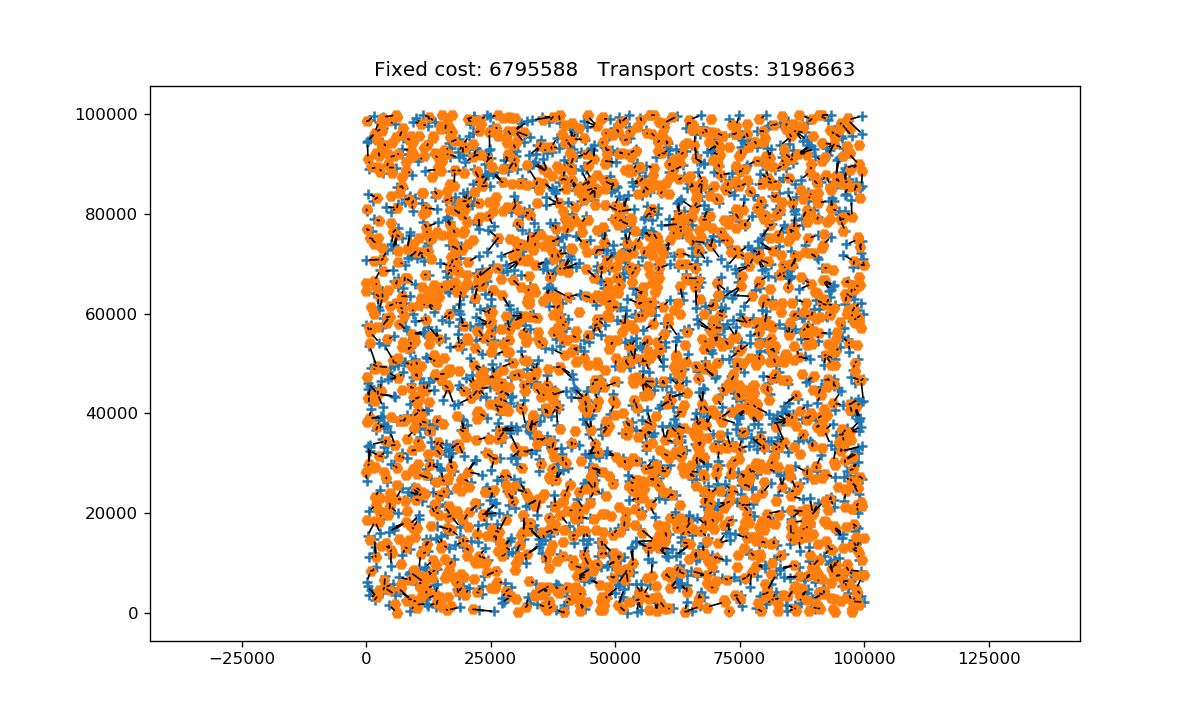

In [82]:
%matplotlib notebook
visualise_solution(data_dict, lns_problem_8_results_dict)

In [173]:
data_dict

{'facility_cost_array': array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
         8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
         9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
         8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
         7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
         8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
         8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
         6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
         7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
         9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278]),
 'facility_capacity_array': array([4765., 4800., 5543., 5016., 4924., 4775., 5099., 4879., 5702.,
        6183., 5156., 5699., 3467., 4826., 4522., 4471., 5190., 5426.,
        4633., 6794., 5302., 4992., 4445., 4483., 5686., 5352., 4562.,
        5514., 4065., 5043., 4905., 5580., 5184., 5346.